In [3]:
from arcgis.gis import GIS
gis = GIS("home")

In [4]:
%matplotlib inline
#ArcGIS packages
import arcpy
#from arcgis.mapping import WebScene
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from IPython.display import display
from arcgis.features import GeoAccessor
from arcgis import *
from arcpy.sa import Int
# Raster processing for dataframe
from rasterstats import zonal_stats
import rasterio

# basic packages
import csv
import numpy as np
import os
import timeit
import random
import string
from playsound import playsound
import gc # Force Garbage Collection. This helps reduce memory leaks in long loops.
import warnings
from pathlib import Path
import time
import threading
from collections import defaultdict
from tqdm import tqdm #Bar status 

# Data management
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  # to get points from long lat

# Request service
#from requests import Request
import json
import re
from functools import reduce
#from owslib.wfs import WebFeatureService
import sqlite3

# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
final_df = pd.read_csv(r"D:\NDIS_Database\zonal_chunks\all_chunks_combined.csv")
final_df.info()

C:/Users/Dell/AppData/Local/Temp/ArcGISProTemp23768/xpython_23768/1754752216.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv(r"D:\NDIS_Database\zonal_chunks\all_chunks_combined.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938335 entries, 0 to 1938334
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   intensity              float64
 6   economic_loss_million  float64
 7   duration_minutes       float64
 8   pop                    float64
 9   pop_flagged            object 
dtypes: float64(7), int64(1), object(2)
memory usage: 147.9+ MB


In [4]:
# Select only the desired columns from merged_df_final
ghz_df  = final_df[[
    "HazardID",
    "latitude",
    "longitude",
    "HazardType",
    "distance",
    "intensity",
    "economic_loss_million",
    "duration_minutes",
    "pop"
]].copy()
ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938335 entries, 0 to 1938334
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   intensity              float64
 6   economic_loss_million  float64
 7   duration_minutes       float64
 8   pop                    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 133.1+ MB


In [21]:
# Mask for all invalid distance values (NaN or <= 0)
invalid_mask = ghz_df['distance'].isna() | (ghz_df['distance'] <= 0)

# Exclude Earthquakes and distance == 0
excluded_mask = (ghz_df['distance'] == 0)

# Final filtered DataFrame
invalid_distance_df = ghz_df[invalid_mask & ~excluded_mask].copy()

print("Filtered invalid distances:", len(invalid_distance_df))
print(invalid_distance_df.head())

Filtered invalid distances: 115325
        HazardID  latitude  longitude HazardType  distance  intensity  \
920449    234001   -37.830     77.520    Volcano       NaN        NaN   
920450    234002   -38.720     77.530    Volcano       NaN        NaN   
920451    234010   -53.106     73.513    Volcano       NaN        NaN   
920452    234030   -46.430     52.200    Volcano       NaN        NaN   
920453    234040   -46.420     51.750    Volcano       NaN        NaN   

        economic_loss_million  duration_minutes  pop  
920449                    NaN               NaN  0.0  
920450                    NaN               NaN  0.0  
920451                    NaN               NaN  0.0  
920452                    NaN               NaN  0.0  
920453                    NaN               NaN  0.0  


In [22]:
invalid_distance_df

,HazardID,latitude,longitude,HazardType,distance,intensity,economic_loss_million,duration_minutes,pop
920449,234001,-37.830,77.520,Volcano,NaN,NaN,NaN,NaN,0.0
920450,234002,-38.720,77.530,Volcano,NaN,NaN,NaN,NaN,0.0
920451,234010,-53.106,73.513,Volcano,NaN,NaN,NaN,NaN,0.0
920452,234030,-46.430,52.200,Volcano,NaN,NaN,NaN,NaN,0.0
920453,234040,-46.420,51.750,Volcano,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
1048297,764561,-58.416,-25.321,Tsunami,NaN,1.0,2.55,20.0,0.0
1048303,763500,-6.852,72.110,Tsunami,NaN,1.0,0.50,20.0,0.0
1048320,763283,1.500,-79.500,Tsunami,NaN,2.0,3.00,73.0,0.0
1048321,763476,1.555,-79.276,Tsunami,NaN,2.0,8.00,86.0,0.0


In [14]:
invalid_distance_df.to_csv(r"D:\NDIS_Database\06_Infrastructureinvalid_distance_df.csv", index=False)

In [20]:
# Count invalid distances per HazardType (excluding Earthquake and distance == 0)
invalid_counts = invalid_distance_df['HazardType'].value_counts()

print(invalid_counts)

HazardType
Earthquake    85569
Fault         29304
Landslide       357
Tsunami          49
Volcano          46
Name: count, dtype: int64


In [4]:
# Load Drone and Sensor data
drone_df = pd.read_csv(r"D:\NDIS_Database\rpas_db0524.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_df = pd.read_csv(r"D:\NDIS_Database\sensors.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           153 non-null    float64
 9   distance_range      70 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             101 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               110 non-null    object 
 16  gps_accu

In [29]:
start_time = timeit.default_timer()

# Paths
project_folder = r"D:\ArcGISProjects\GeohazardDB"

ndis_gdb = os.path.join(project_folder, "ghzgdb_Legacy.gdb")
road_gdb = os.path.join(project_folder, "GeohazardDB.gdb")
road_layer_template = os.path.join(road_gdb, "roads")
country_layer = os.path.join(road_gdb, "eez_country")

invalid_layer = os.path.join(road_gdb, "invalid_distance")  # input geohazard points

# Near analysis preparation
ghz_list = []
near_tables = []

total_countries = int(arcpy.GetCount_management(country_layer)[0])

with arcpy.da.SearchCursor(country_layer, ["ISO_TER1", "SHAPE@"]) as country_cursor:
    for index, row in enumerate(country_cursor, start=1):
        iso = row[0]
        shape = row[1]
        print(f"⏳ Processing {iso} ({index}/{total_countries})...")

        inv_clip = os.path.join(ndis_gdb, f"invdist_{iso}")
        road_clip = os.path.join(road_gdb, f"road_{iso}")
        near_table = os.path.join(ndis_gdb, f"near_invdist_{iso}")

        # Clip invalid geohazard points
        if arcpy.Exists(inv_clip):
            arcpy.Delete_management(inv_clip)
        arcpy.analysis.Clip(invalid_layer, shape, inv_clip)

        # Run Near analysis
        if arcpy.Exists(near_table):
            arcpy.Delete_management(near_table)
        arcpy.analysis.GenerateNearTable(
            in_features=inv_clip,
            near_features=road_clip,
            out_table=near_table,
            location="LOCATION",
            angle="ANGLE",
            closest="CLOSEST",
            method="GEODESIC"
        )
        print(f"  ✅ Near table created: {near_table}")
        near_tables.append(near_table)

        # Add 'distance' to inv_clip
        if "distance" not in [f.name for f in arcpy.ListFields(inv_clip)]:
            arcpy.AddField_management(inv_clip, "distance", "DOUBLE")

        with arcpy.da.UpdateCursor(inv_clip, ["OBJECTID", "distance"]) as up_cursor:
            for up_row in up_cursor:
                oid = up_row[0]
                with arcpy.da.SearchCursor(near_table, ["IN_FID", "NEAR_DIST"]) as near_cursor:
                    for near_row in near_cursor:
                        if near_row[0] == oid:
                            up_row[1] = near_row[1]
                            up_cursor.updateRow(up_row)
                            break

        # Add 'HazardID' to near table
        if "HazardID" not in [f.name for f in arcpy.ListFields(near_table)]:
            arcpy.AddField_management(near_table, "HazardID", "TEXT")

        with arcpy.da.UpdateCursor(near_table, ["IN_FID", "HazardID"]) as cursor:
            for row in cursor:
                with arcpy.da.SearchCursor(inv_clip, ["OBJECTID", "HazardID"]) as src:
                    for src_row in src:
                        if row[0] == src_row[0]:
                            row[1] = src_row[1]
                            cursor.updateRow(row)
                            break

        ghz_list.append(inv_clip)

# Merge clipped geohazard points
merged_output = os.path.join(ndis_gdb, "invalid_dist_merged")
if arcpy.Exists(merged_output):
    arcpy.Delete_management(merged_output)
arcpy.Merge_management(ghz_list, merged_output)
print(f"✅ All invalid geohazard points merged into {merged_output}")

# Merge near tables
compiled_near_table = os.path.join(ndis_gdb, "compiled_near_table_invalid")
if arcpy.Exists(compiled_near_table):
    arcpy.Delete_management(compiled_near_table)

arcpy.CreateTable_management(ndis_gdb, "compiled_near_table_invalid")
for field in [("FROM_X", "DOUBLE"), ("FROM_Y", "DOUBLE"), ("NEAR_X", "DOUBLE"),
              ("NEAR_Y", "DOUBLE"), ("NEAR_FID", "LONG"), ("HazardID", "TEXT")]:
    arcpy.AddField_management(compiled_near_table, field[0], field[1])

with arcpy.da.InsertCursor(compiled_near_table, ["FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y", "NEAR_FID", "HazardID"]) as insert_cursor:
    for table in near_tables:
        with arcpy.da.SearchCursor(table, ["FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y", "NEAR_FID", "HazardID"]) as cursor:
            for row in cursor:
                insert_cursor.insertRow(row)

# Create line layer
line_fc = os.path.join(ndis_gdb, "compiled_near_lines_invalid")
if arcpy.Exists(line_fc):
    arcpy.Delete_management(line_fc)

arcpy.XYToLine_management(
    compiled_near_table, line_fc, 
    "FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y"
)
print(f"✅ Lines created: {line_fc}")

elapsed = timeit.default_timer() - start_time
print(f"✅ All invalid distance near analysis completed in {elapsed/60:.2f} minutes")


⏳ Processing JOR (1/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_JOR
⏳ Processing BDI (2/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_BDI
⏳ Processing URJ (3/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_URJ
⏳ Processing LVA (4/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_LVA
⏳ Processing BDZ (5/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_BDZ
⏳ Processing BLR (6/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_BLR
⏳ Processing HUN (7/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_HUN
⏳ Processing TJK (8/328)...
  ✅ Near table created: D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\near_invdist_TJK
⏳ Processing SOD (9/328)...
  ✅ Near table created: D:\ArcGISPro

------

# PreProcessing for Staggered Decision v3.8.0

In [6]:
# Get the recalculated invalid distance
# Path to the merged feature class
merged_fc = r"D:\ArcGISProjects\GeohazardDB\ghzgdb_Legacy.gdb\invalid_dist_merged"

# List fields you want to extract
fields = [f.name for f in arcpy.ListFields(merged_fc) if f.type not in ("Geometry", "OID")]

# Add geometry fields if needed
fields += ["SHAPE@XY"]

# Read into a DataFrame
data = []
with arcpy.da.SearchCursor(merged_fc, fields) as cursor:
    for row in cursor:
        data.append(row)

# Create DataFrame
invalid_dist_df = pd.DataFrame(data, columns=fields)

invalid_dist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6011 entries, 0 to 6010
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               6011 non-null   int64  
 1   latitude               6011 non-null   float64
 2   longitude              6011 non-null   float64
 3   HazardType             6011 non-null   object 
 4   distance               356 non-null    object 
 5   intensity              51 non-null     object 
 6   economic_loss_million  51 non-null     object 
 7   duration_minutes       51 non-null     object 
 8   pop                    6011 non-null   float64
 9   SHAPE@XY               6011 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 469.7+ KB


In [7]:
# Filter only rows with non-null distance
valid_distance_df = invalid_dist_df[invalid_dist_df["distance"].notna()].copy()

# Show count and preview
print("Valid distances extracted:", len(valid_distance_df))
print(valid_distance_df[["HazardID", "distance"]].head())

Valid distances extracted: 356
   HazardID          distance
0      1012   1471.6241757914
1      3603  7653.21392621024
2      1848  3582.60777272442
3      3108  2329.97952183445
4      2973  869.561002507594


In [9]:
# Select only the desired columns from merged_df_final
valid_distance_df  = valid_distance_df[[
    "HazardID",
    "latitude",
    "longitude",
    "HazardType",
    "distance",
    "intensity",
    "economic_loss_million",
    "duration_minutes",
    "pop"
]].copy()
valid_distance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 0 to 4545
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               356 non-null    int64  
 1   latitude               356 non-null    float64
 2   longitude              356 non-null    float64
 3   HazardType             356 non-null    object 
 4   distance               356 non-null    object 
 5   intensity              2 non-null      object 
 6   economic_loss_million  2 non-null      object 
 7   duration_minutes       2 non-null      object 
 8   pop                    356 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.8+ KB


In [10]:
nuclear = ghz_df[(ghz_df["HazardType"] == "Nuclear")]
nuclear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6119 entries, 914330 to 920448
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               6119 non-null   int64  
 1   latitude               6119 non-null   float64
 2   longitude              6119 non-null   float64
 3   HazardType             6119 non-null   object 
 4   distance               6119 non-null   float64
 5   intensity              6119 non-null   float64
 6   economic_loss_million  6119 non-null   float64
 7   duration_minutes       6119 non-null   float64
 8   pop                    6119 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 478.0+ KB


In [15]:
nuclear

,HazardID,latitude,longitude,HazardType,distance,intensity,economic_loss_million,duration_minutes,pop
914330,1110500502,-33.96701,-59.20950,Nuclear,401.918796,5.0,4163.0,1440.0,162494.0
914331,1110500382,-33.96720,-59.20730,Nuclear,256.196159,5.0,8567.5,1440.0,163124.0
914332,1110500646,-33.96720,-59.20750,Nuclear,264.593305,5.0,0.0,1440.0,163062.0
914333,1110500600,-33.96780,-59.21301,Nuclear,451.689429,5.0,333.5,1440.0,161574.0
914334,1110500385,-32.23160,-64.44220,Nuclear,318.694090,5.0,7544.0,1440.0,35389.0
...,...,...,...,...,...,...,...,...,...
920444,1110501496,11.69030,109.17510,Nuclear,32.259321,5.0,0.0,1440.0,464227.0
920445,1110501493,11.69030,109.17510,Nuclear,32.259321,5.0,0.0,1440.0,464227.0
920446,1110501494,11.69030,109.17510,Nuclear,32.259321,5.0,0.0,1440.0,464227.0
920447,1110501495,11.69030,109.17510,Nuclear,32.259321,5.0,0.0,1440.0,464227.0


In [16]:
# Find duplicated HazardIDs
duplicates = nuclear[nuclear.duplicated("HazardID", keep=False)]

print("Total duplicated HazardIDs:", duplicates["HazardID"].nunique())
print("Duplicated entries:")
print(duplicates.sort_values("HazardID").head())


Total duplicated HazardIDs: 1382
Duplicated entries:
          HazardID  latitude  longitude HazardType     distance  intensity  \
920348  1110008838  25.43448   -80.3324    Nuclear  7983.791226        5.0   
920352  1110008838  25.43448   -80.3324    Nuclear  7983.791226        5.0   
920360  1110008838  25.43448   -80.3324    Nuclear  7983.791226        5.0   
920356  1110008838  25.43448   -80.3324    Nuclear  7983.791226        5.0   
920361  1110008843  25.43448   -80.3324    Nuclear  7983.791226        5.0   

        economic_loss_million  duration_minutes       pop  
920348                 9533.5            1440.0  665367.0  
920352                 9533.5            1440.0  665367.0  
920360                    0.0            1440.0  665367.0  
920356                    0.0            1440.0  665367.0  
920361                    0.0            1440.0  665367.0  


In [6]:
cleaned_nuclear_df = pd.read_csv(r"D:\NDIS_Database\cleaned_nuclear_df.csv")
cleaned_nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   intensity              1541 non-null   float64
 5   duration_minutes       1541 non-null   float64
 6   economic_loss_million  1541 non-null   float64
 7   travel_time            0 non-null      float64
 8   monitor_time           1541 non-null   float64
 9   cpm_total_time         0 non-null      float64
 10  HazardStage            1541 non-null   object 
 11  pop                    1541 non-null   float64
 12  distance               1541 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 156.6+ KB


In [23]:
# Define fields to check
fields_to_check = ["distance", "pop", "economic_loss_million", "intensity", "duration_minutes"]

# Tier 1: Fully valid rows
valid_mask = nuclear[fields_to_check].notna().all(axis=1) & (nuclear[fields_to_check] > 0).all(axis=1)
valid_df = nuclear[valid_mask].copy()
valid_df = valid_df.sort_values("economic_loss_million", ascending=False)
valid_dedup = valid_df.drop_duplicates(subset="HazardID", keep="first")

# Tier 2: All remaining HazardIDs not in Tier 1
remaining_df = nuclear[~nuclear["HazardID"].isin(valid_dedup["HazardID"])]
fallback_dedup = remaining_df.drop_duplicates(subset="HazardID", keep="first")

# Combine both
final_dedup = pd.concat([valid_dedup, fallback_dedup], ignore_index=True)

print("✅ Final deduplicated nuclear count:", len(final_dedup))


✅ Final deduplicated nuclear count: 1541


In [24]:
final_dedup

,HazardID,latitude,longitude,HazardType,distance,intensity,economic_loss_million,duration_minutes,pop
0,1110500815,22.6056,114.5531,Nuclear,318.609479,5.0,11385.0,1440.0,1503334.0
1,1110500245,38.0601,-77.7897,Nuclear,2121.211036,5.0,11385.0,1440.0,105858.0
2,1110500818,22.6056,114.5531,Nuclear,318.609479,5.0,11385.0,1440.0,1503334.0
3,1110500817,22.6056,114.5531,Nuclear,318.609479,5.0,11385.0,1440.0,1503334.0
4,1110500247,33.9597,-78.0114,Nuclear,1618.419563,5.0,11385.0,1440.0,179163.0
...,...,...,...,...,...,...,...,...,...
1536,1110501492,11.4109,108.9743,Nuclear,253.455295,5.0,0.0,1440.0,472356.0
1537,1110501493,11.6903,109.1751,Nuclear,32.259321,5.0,0.0,1440.0,464227.0
1538,1110501494,11.6903,109.1751,Nuclear,32.259321,5.0,0.0,1440.0,464227.0
1539,1110501495,11.6903,109.1751,Nuclear,32.259321,5.0,0.0,1440.0,464227.0


In [25]:
# Step 1: Remove all existing Nuclear rows from ghz_df
ghz_df_no_nuclear = ghz_df[ghz_df["HazardType"] != "Nuclear"].copy()

# Step 2: Append final deduplicated nuclear DataFrame
ghz_updated = pd.concat([ghz_df_no_nuclear, final_dedup], ignore_index=True)

# Step 3: Update rows using valid_distance_df
# We'll use HazardID as the join key and update all matching rows

# Ensure HazardID is same dtype
valid_distance_df["HazardID"] = valid_distance_df["HazardID"].astype(ghz_updated["HazardID"].dtype)

# Set HazardID as index for fast lookup
ghz_updated.set_index("HazardID", inplace=True)
valid_distance_df.set_index("HazardID", inplace=True)

# Update all overlapping columns with corrected values
ghz_updated.update(valid_distance_df)

# Reset index
ghz_updated.reset_index(inplace=True)

# Done
print("Final GHZ DataFrame shape:", ghz_updated.shape)


Final GHZ DataFrame shape: (1933757, 9)


In [13]:
volcano = ghz_updated[(ghz_updated["HazardType"] == "Volcano")]
volcano.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090 entries, 914330 to 1043259
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1090 non-null   int64  
 1   latitude               1090 non-null   float64
 2   longitude              1090 non-null   float64
 3   HazardType             1090 non-null   object 
 4   distance               1044 non-null   float64
 5   intensity              1044 non-null   float64
 6   economic_loss_million  1044 non-null   float64
 7   duration_minutes       1044 non-null   float64
 8   pop                    1090 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 85.2+ KB


In [15]:
volcano['distance'].notna().sum()

1044

In [27]:
ghz_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933757 entries, 0 to 1933756
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               object 
 5   intensity              object 
 6   economic_loss_million  object 
 7   duration_minutes       object 
 8   pop                    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 132.8+ MB


In [36]:
ghz_updated['distance'].isna().unique()

array([False,  True])

In [8]:
ghz_updated['distance'].notna().sum()

1818788

In [9]:
1933757 - 1818788

114969

In [11]:
(114969/1933757)*100

5.945369557808969

In [52]:
ghz_updated.to_csv(r"D:\NDIS_Database\ghz_updated_250722.csv", index=False)

In [58]:
# Paths
project_folder = r"D:\ArcGISProjects\GeohazardDB"
output_gdb = arcpy.CreateFileGDB_management(project_folder, "ndis3.gdb")
output_fc = os.path.join(project_folder, "ndis3.gdb", "ghz_updated_fc")

# Convert to spatially-enabled DataFrame (requires lat/lon in WGS 1984)
sdf = pd.DataFrame(ghz_updated.copy())
sdf = sdf[sdf["latitude"].notna() & sdf["longitude"].notna()]  # Ensure valid coordinates

# Create point geometry
geometry = [arcpy.Point(row["longitude"], row["latitude"]) for idx, row in sdf.iterrows()]
spatial_ref = arcpy.SpatialReference(4326)  # WGS 1984
features = [arcpy.Polygon(arcpy.Array([pt]), spatial_ref) if isinstance(pt, arcpy.Point) else None for pt in geometry]

# Create Feature Class from scratch
if arcpy.Exists(output_fc):
    arcpy.Delete_management(output_fc)
arcpy.CreateFeatureclass_management(out_path=os.path.dirname(output_fc), out_name=os.path.basename(output_fc),
                                    geometry_type="POINT", spatial_reference=spatial_ref)

# Add fields from DataFrame (skip lat/lon and geometry)
fields_to_add = [col for col in sdf.columns if col not in ["latitude", "longitude"]]
for field in fields_to_add:
    sample_value = sdf[field].dropna().iloc[0] if not sdf[field].dropna().empty else ""
    field_type = "TEXT"
    if pd.api.types.is_integer_dtype(sdf[field]):
        field_type = "LONG"
    elif pd.api.types.is_float_dtype(sdf[field]):
        field_type = "DOUBLE"
    arcpy.AddField_management(output_fc, field, field_type)

# Write to feature class
insert_fields = ["SHAPE@"] + fields_to_add
with arcpy.da.InsertCursor(output_fc, insert_fields) as cursor:
    for idx, row in sdf.iterrows():
        pt = arcpy.Point(row["longitude"], row["latitude"])
        values = [pt] + [row[f] for f in fields_to_add]
        cursor.insertRow(values)

print(f"✅ Feature class created: {output_fc}")

✅ Feature class created: D:\ArcGISProjects\GeohazardDB\ndis3.gdb\ghz_updated_fc


In [28]:
# Check for null or zero in 'pop' and 'distance'
invalid_pop_dist = ghz_updated[
    (ghz_updated["pop"].isna() | (ghz_updated["pop"] == 0)) |
    (ghz_updated["distance"].isna() | (ghz_updated["distance"] == 0))
]

# Show summary
print("❗ Rows with null or zero in pop or distance:", len(invalid_pop_dist))
print(invalid_pop_dist[["HazardID", "HazardType", "pop", "distance"]].head())

❗ Rows with null or zero in pop or distance: 891646
   HazardID  HazardType  pop       distance
0  16104462  Earthquake  0.0  105682.800646
1  16104463  Earthquake  0.0   444950.02603
2  16104464  Earthquake  0.0    7365.619676
5  16104469  Earthquake  0.0   53872.618983
6  16104470  Earthquake  0.0   439522.47189


In [29]:
invalid_pop_dist.to_csv(r"D:\NDIS_Database\19_PostProcessing\invalid_pop_dist.csv", index=False)

------
# STAGGERED DECISION 3.8.0
------

In [3]:
# Load Drone and Sensor data
drone_df = pd.read_csv("D:/NDIS_Database/rpas_db0524.csv") # 179 RPAS
sensor_df = pd.read_csv("D:/NDIS_Database/sensors.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           153 non-null    float64
 9   distance_range      70 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             101 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               110 non-null    object 
 16  gps_accu

In [46]:
ghz_updated = pd.read_csv(r"D:\NDIS_Database\ghz_updated_250722.csv")
ghz_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933757 entries, 0 to 1933756
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   intensity              float64
 6   economic_loss_million  float64
 7   duration_minutes       float64
 8   pop                    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 132.8+ MB


In [52]:
ghz_updated.to_csv(r"D:\NDIS_Database\ghz_updated_rbin.csv", index=False)

In [48]:
def classify_road_distance(d):
    if d < 1000:
        return "<1 km"
    elif 1000 <= d < 5000:
        return "1–5 km"
    elif 5000 <= d < 20000:
        return "5–20 km"
    elif 20000 <= d < 50000:
        return "20–50 km"
    else:
        return ">50 km"

ghz_updated["road_bin"] = ghz_updated["distance"].apply(classify_road_distance)
ghz_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933757 entries, 0 to 1933756
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   intensity              float64
 6   economic_loss_million  float64
 7   duration_minutes       float64
 8   pop                    float64
 9   road_bin               object 
dtypes: float64(7), int64(1), object(2)
memory usage: 147.5+ MB


In [51]:
def classify_population_bins(p):
    if p == 0:
        return "0"
    elif p < 1000:
        return "<1k"
    elif p < 10000:
        return "1k–10k"
    elif p < 100000:
        return "10k–100k"
    elif p < 1000000:
        return "100k–1M"
    elif p < 10000000:
        return "1M–10M"
    else:
        return ">10M"

ghz_updated["pop_bin"] = ghz_updated["pop"].apply(classify_population_bins)
ghz_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933757 entries, 0 to 1933756
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   intensity              float64
 6   economic_loss_million  float64
 7   duration_minutes       float64
 8   pop                    float64
 9   road_bin               object 
 10  pop_bin                object 
dtypes: float64(7), int64(1), object(3)
memory usage: 162.3+ MB


In [24]:
# Read data
nuclear_df = pd.read_csv(r"D:\NDIS_Database\15_NuclearPower\nuclearpp.csv")
nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date Last Researched                      1541 non-null   object 
 1   Country/Area                              1541 non-null   object 
 2   Project Name                              1541 non-null   object 
 3   Unit Name                                 1541 non-null   object 
 4   Project Name in Local Language / Script   361 non-null    object 
 5   Other Name(s)                             333 non-null    object 
 6   Capacity (MW)                             1541 non-null   object 
 7   Status                                    1541 non-null   object 
 8   Reactor Type                              1541 non-null   object 
 9   Model                                     1541 non-null   object 
 10  Start Year                          

In [35]:
nuclear_df

,Date Last Researched,Country/Area,Project Name,Unit Name,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Status,Reactor Type,Model,...,Location Accuracy,City,"Local Area (taluk, county)","Major Area (prefecture, district)",State/Province,Subregion,Region,GEM location ID,GEM unit ID,Wiki URL
0,2024-05-22,Argentina,Atucha nuclear power plant,1,NaN,Unit IV (Phase 3),362,operating,pressurized heavy water reactor,PHWR KWU,...,exact,NaN,NaN,Partido de Zárate,Buenos Aires,Latin America and the Caribbean,Americas,L100000500166,G100000500502,https://www.gem.wiki/Atucha_nuclear_power_plant
1,2024-05-22,Argentina,Atucha nuclear power plant,2,NaN,Unit IV (Phase 3),745,operating,pressurized heavy water reactor,PHWR KWU,...,exact,NaN,NaN,Partido de Zárate,Buenos Aires,Latin America and the Caribbean,Americas,L100000500166,G100000500382,https://www.gem.wiki/Atucha_nuclear_power_plant
2,2024-05-22,Argentina,Atucha nuclear power plant,3,NaN,Unit IV (Phase 3),"1,150",pre-construction,pressurized water reactor,Hualong One,...,exact,NaN,NaN,Partido de Zárate,Buenos Aires,Latin America and the Caribbean,Americas,L100000500166,G100000500646,https://www.gem.wiki/Atucha_nuclear_power_plant
3,2024-05-22,Argentina,CAREM nuclear power plant,--,Central Argentina de Elementos Modulares,CAREM25,29,mothballed,pressurized water reactor,CAREM Prototype (Integrated-PWR),...,exact,NaN,NaN,Partido de Zárate,Buenos Aires,Latin America and the Caribbean,Americas,L100000500252,G100000500600,https://www.gem.wiki/CAREM_nuclear_power_plant
4,2024-05-22,Argentina,Embalse nuclear power plant,--,NaN,NaN,656,operating,pressurized heavy water reactor,CANDU 6,...,exact,NaN,Pedanía Cañada de Álvarez,Departamento Calamuchita,Córdoba,Latin America and the Caribbean,Americas,L100000500169,G100000500385,https://www.gem.wiki/Embalse_nuclear_power_plant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,2024-05-16,Vietnam,Ninh Thuận 1 nuclear power plant,4,NaN,NaN,"1,200",cancelled,pressurized water reactor,VVER-1200/V-491,...,exact,NaN,Thuận Nam District,NaN,Ninh Thuận Province,South-eastern Asia,Asia,L100000500518,G100000501492,https://www.gem.wiki/Ninh_Thuận_1_nuclear_powe...
1537,2024-05-16,Vietnam,Ninh Thuận 2 nuclear power plant,1,NaN,NaN,"1,100",cancelled,pressurized water reactor,ATMEA1,...,exact,NaN,Ninh Hải District,NaN,Ninh Thuận Province,South-eastern Asia,Asia,L100000500519,G100000501493,https://www.gem.wiki/Ninh_Thuận_2_nuclear_powe...
1538,2024-05-16,Vietnam,Ninh Thuận 2 nuclear power plant,2,NaN,NaN,"1,100",cancelled,pressurized water reactor,ATMEA1,...,exact,NaN,Ninh Hải District,NaN,Ninh Thuận Province,South-eastern Asia,Asia,L100000500519,G100000501494,https://www.gem.wiki/Ninh_Thuận_2_nuclear_powe...
1539,2024-05-16,Vietnam,Ninh Thuận 2 nuclear power plant,3,NaN,NaN,"1,100",cancelled,pressurized water reactor,ATMEA1,...,exact,NaN,Ninh Hải District,NaN,Ninh Thuận Province,South-eastern Asia,Asia,L100000500519,G100000501495,https://www.gem.wiki/Ninh_Thuận_2_nuclear_powe...


In [25]:
nuclear = ghz_updated[(ghz_updated["HazardType"] == "Nuclear")]
nuclear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 1932216 to 1933756
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   distance               1541 non-null   float64
 5   intensity              1541 non-null   float64
 6   economic_loss_million  1541 non-null   float64
 7   duration_minutes       1541 non-null   float64
 8   pop                    1541 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 120.4+ KB


In [37]:
# List of columns to extract from the 'nuclear_df' dataframe, including Latitude and Longitude
selected_columns = [
    "Country/Area", 
    "Project Name", 
    "Capacity (MW)", 
    "Status", 
    "Reactor Type", 
    "Owner", 
    "Wiki URL",
    "Latitude",  # Include Latitude for matching
    "Longitude"  # Include Longitude for matching
]

# Select only the relevant columns from the 'nuclear_df' dataframe
nuclear_df_selected = nuclear_df[selected_columns]

# Ensure that latitudes and longitudes are of float type in both dataframes
nuclear_df_selected.loc[:, 'Latitude'] = nuclear_df_selected['Latitude'].astype(float)
nuclear_df_selected.loc[:, 'Longitude'] = nuclear_df_selected['Longitude'].astype(float)
nuclear.loc[:, 'latitude'] = nuclear['latitude'].astype(float)
nuclear.loc[:, 'longitude'] = nuclear['longitude'].astype(float)

# Define a function to match latitude and longitude with a small tolerance
def match_lat_lon(row, df, tolerance=0.001):
    # Match latitudes and longitudes within a tolerance range
    matched_row = df[
        (df['Latitude'].between(row['latitude'] - tolerance, row['latitude'] + tolerance)) &
        (df['Longitude'].between(row['longitude'] - tolerance, row['longitude'] + tolerance))
    ]
    if not matched_row.empty:
        return matched_row.iloc[0]  # Return the first matched row
    return None  # Return None if no match is found

# Merge based on matching latitude and longitude
merged_rows = []
for idx, row in nuclear.iterrows():
    matched_row = match_lat_lon(row, nuclear_df_selected)
    if matched_row is not None:
        # Combine the original row from 'nuclear' with matched fields from 'nuclear_df'
        merged_row = pd.concat([row, matched_row], axis=0)
        merged_rows.append(merged_row)

# Convert merged rows into a new DataFrame
merged_nuclear = pd.DataFrame(merged_rows)
merged_nuclear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   distance               1541 non-null   float64
 5   intensity              1541 non-null   float64
 6   economic_loss_million  1541 non-null   float64
 7   duration_minutes       1541 non-null   float64
 8   pop                    1541 non-null   float64
 9   Country/Area           1541 non-null   object 
 10  Project Name           1541 non-null   object 
 11  Capacity (MW)          1541 non-null   object 
 12  Status                 1541 non-null   object 
 13  Reactor Type           1541 non-null   object 
 14  Owner                  1389 non-null   object 
 15  Wiki

In [38]:
merged_nuclear.to_csv(r"D:\NDIS_Database\15_NuclearPower\merged_nuclear.csv", index=False)

In [17]:
drone_df.to_csv(r"D:\NDIS_Database\drone_df.csv", index=False)

In [6]:
# Output folder path
output_folder = r"D:\NDIS_Database\20_PaperSimulation\csv_exports"
os.makedirs(output_folder, exist_ok=True)

# Loop through each hazard type and export
for hazard in ghz_updated["HazardType"].unique():
    df_hazard = ghz_updated[ghz_updated["HazardType"] == hazard].copy()
    file_name = hazard.replace(" ", "_").replace("-", "_") + ".csv"
    output_path = os.path.join(output_folder, file_name)

    df_hazard.to_csv(output_path, index=False)
    print(f"✅ Exported: {output_path}")

✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Earthquake.csv
✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Landslide.csv
✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Fault.csv
✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Volcano.csv
✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Tsunami.csv
✅ Exported: D:\NDIS_Database\20_PaperSimulation\csv_exports\Nuclear.csv


In [9]:
#####  WARNING 040401: NULL geometry ignored. earthquake data
##### ObjectID = 12208, 13016, 15219, 23081, 129143, 129408, 130081, 130944, 131824, 131883, 132339, 132684, 133411, 135393, 137857, 137862, 188864, 203690, 208491, 236256, 324345, 324478, 353914, 383545, 385209, 385512, 585489, 592869, 592874, 647637, 650693, 694169, 694998, 696126, 697331, 705830, 708720, 708746, 723736, 766531, 833594, 833596, 833599, 833601, 833603, 833605, 833777, 848266, 848269, 848270, 848271, 1036599, 1040749, 1051551, 1051684, 1052802, 1067634, 1067638, 1067658, 1069820, 1070828, 1071354, 1074495, 1074916, 1075693, 1076045, 1084575, 1086248, 1167464, 1240294, 1315774, 1424012, 1598363, 1626785, 1650808, 1669159, 1728557, 1729656

In [33]:
# Drop NaNs first (optional)
grouped_exact = drone_df.dropna(subset=["comm_range"]).groupby("comm_range")

# Count per group
print(grouped_exact.size())

comm_range
60.0         1
300.0        1
500.0        1
1000.0       6
1500.0       6
2000.0      12
3000.0       5
3200.0       1
3500.0       2
4000.0       5
5000.0       9
5954.0       1
7000.0       2
7500.0       1
8000.0      11
10000.0      8
12000.0      3
15000.0      4
16000.0      8
20000.0     10
22500.0      1
35000.0      1
40000.0      1
45000.0      3
50000.0      3
80000.0      2
100000.0     7
200000.0     1
400000.0     1
500000.0     1
dtype: int64


In [35]:
def classify_comm(m):
    if pd.isna(m):
        return "Unknown"
    elif m < 1000:
        return "<1km"
    elif m < 5000:
        return "1–5km"
    elif m < 20000:
        return "5–20km"
    elif m < 50000:
        return "20–50km"
    else:
        return ">50km"

drone_df["comm_category"] = drone_df["comm_range"].apply(classify_comm)
comm_count = drone_df["comm_category"].value_counts().reindex(["<1km", "1–5km", "5–20km", "20–50km", ">50km", "Unknown"], fill_value=0)

print(comm_count)


comm_category
<1km        3
1–5km      37
5–20km     47
20–50km    16
>50km      15
Unknown    61
Name: count, dtype: int64


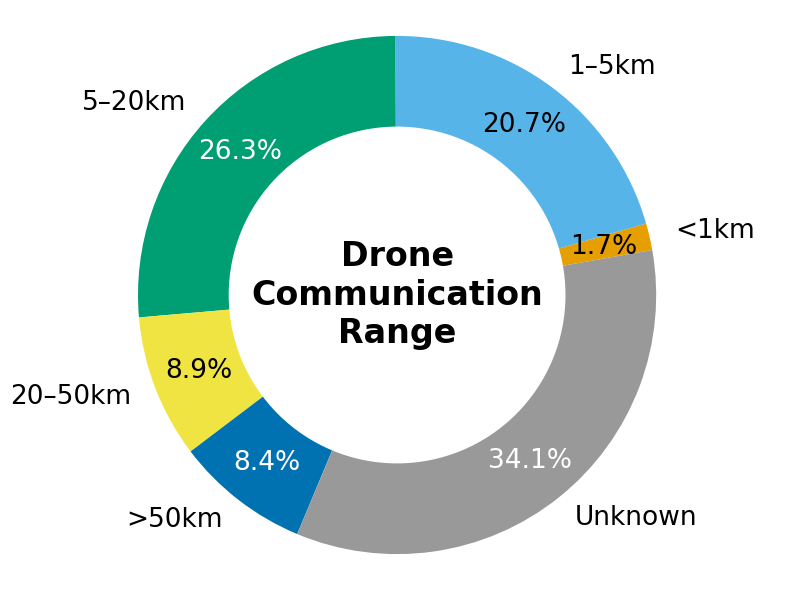

In [48]:
comm_countsr = pd.Series({
    "<1km": 3,
    "1–5km": 37,
    "5–20km": 47,
    "20–50km": 16,
    ">50km": 15,
    "Unknown": 61
})

# Define colorblind-safe palette including one for "Unknown"
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999"]

# Normalize for brightness check
def get_text_color(hex_color):
    rgb = mcolors.hex2color(hex_color)
    brightness = np.dot(rgb, [0.299, 0.587, 0.114])  # luminance
    return 'black' if brightness > 0.6 else 'white'

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.9, bottom=0.2)
wedges, texts, autotexts = ax.pie(
    comm_countsr,
    labels=comm_countsr.index,
    autopct='%1.1f%%',
    startangle=10,
    pctdistance=0.82,
    wedgeprops=dict(width=0.4),
    colors=colors
)

# Adjust text styles
for i, autotext in enumerate(autotexts):
    autotext.set_color(get_text_color(colors[i]))
    autotext.set_fontsize(19)
for t in texts:
    t.set_fontsize(19)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(centre_circle)

# Add center title
ax.text(0, 0, "Drone\nCommunication\nRange", ha='center', va='center', fontsize=24, weight='bold', color='black')

# Caption
#plt.figtext(0.5, 0.025,
#    "Distribution of drone communication range (including unknown values).",
#    wrap=True, horizontalalignment='center', fontsize=18)

ax.axis('equal')
plt.tight_layout()

# Save if needed
plt.savefig(r'D:\NDIS_Database\13_NDIS_Display\Page3\pictures\drone_comm2.png', dpi=300, transparent=True)

plt.show()

# STAGE 2: Assign Disaster Phase

In [5]:
ghz_updated.HazardType.unique()

array(['Earthquake', 'Landslide', 'Fault', 'Volcano', 'Tsunami',
       'Nuclear'], dtype=object)

In [6]:
# Step 1: Define disaster phase + sensor map
disaster_map = [
    ("Volcano", "Pre-Event", ["Magnetometers", "Seismic", "Camera"]),
    ("Volcano", "During", ["Thermal Camera", "Camera", "LiDAR"]),
    ("Volcano", "Post-Event", ["LiDAR", "Camera", "Seismic"]),
    ("Volcano", "Clean-Up", ["LiDAR", "Camera", "Seismic"]),
    ("Earthquake", "Pre-Event", ["Seismic", "Magnetometers", "Camera"]),
    ("Earthquake", "During", ["Seismic", "Camera", "LiDAR"]),
    ("Earthquake", "Post-Event", ["LiDAR", "Camera", "Seismic"]),
    ("Fault", "Pre-Event", ["Seismic", "Magnetometers", "Camera"]),
    ("Fault", "Post-Event", ["Seismic", "Camera", "LiDAR"]),
    ("Landslide", "Pre-Event", ["LiDAR", "GPR", "Camera"]),
    ("Landslide", "During", ["Camera", "Thermal Camera", "LiDAR"]),
    ("Landslide", "Post-Event", ["LiDAR", "Seismic", "Camera"]),
    ("Landslide", "Clean-Up", ["Camera", "LiDAR", "Seismic"]),
    ("Tsunami", "During", ["BPR", "Camera", "Seismic"]),
    ("Tsunami", "Post-Event", ["BPR", "Camera", "LiDAR"]),
    ("Tsunami", "Clean-Up", ["Camera", "LiDAR", "Thermal Camera"]),
    ("Nuclear", "Pre-Event", ["Thermal Camera", "Camera", "LiDAR"]),
    ("Nuclear", "During", ["Thermal Camera", "Camera", "LiDAR"]),
    ("Nuclear", "Post-Event", ["Camera", "LiDAR", "Gamma Spectrometer"]),
    ("Nuclear", "Clean-Up", ["Camera", "LiDAR", "Gamma Spectrometer"]),
]

In [7]:
disaster_df = pd.DataFrame(disaster_map, columns=["HazardType", "DisasterPhase", "RecommendedSensors"])

# Step 2: Merge every HazardID with its corresponding disaster phases
ghz_core = ghz_updated[["HazardID", "HazardType", "latitude", "longitude"]]  # minimal fields to avoid memory issue
ghz_expanded = ghz_core.merge(disaster_df, on="HazardType", how="left")

# Step 3: Explode to get 1 row per recommended sensor
ghz_expanded = ghz_expanded.explode("RecommendedSensors").rename(columns={"RecommendedSensors": "RecommendedSensor"})
ghz_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16936500 entries, 0 to 5645499
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 904.5+ MB


# STAGE 3: Assign Sensor Weight

In [8]:
# Clean sensor name just in case (strip whitespace)
sensor_df["sensor_name_clean"] = sensor_df["sensor_name"].str.strip()
ghz_expanded["RecommendedSensor_clean"] = ghz_expanded["RecommendedSensor"].str.strip()

# Merge and keep only relevant columns
merged_df = ghz_expanded.merge(
    sensor_df[["sensor_name_clean", "sensor_weight", "model"]],
    left_on="RecommendedSensor_clean",
    right_on="sensor_name_clean",
    how="left"
).drop(columns=["sensor_name_clean", "RecommendedSensor_clean"])

# Rename model to sensor_model
merged_df = merged_df.rename(columns={"model": "sensor_model"})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16936500 entries, 0 to 16936499
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.0+ GB


In [9]:
merged_df.RecommendedSensor.isna().unique()

array([False])

In [10]:
merged_df = merged_df.merge(
    ghz_updated[["HazardID", "distance"]],
    on="HazardID",
    how="left"
)
merged_df["distance"] = pd.to_numeric(merged_df["distance"], errors="coerce")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998132 entries, 0 to 16998131
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
 8   distance           float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ GB


In [35]:
sample = merged_df.sample(100000, random_state=42)
print(sample[["RecommendedSensor", "sensor_weight", "distance", "mission_distance"]])
sample.info()

         RecommendedSensor  sensor_weight       distance  mission_distance
2628958             Camera              5     310.093116       4500.000000
7925175              LiDAR            430            NaN       1000.000000
4497383              LiDAR            430    1585.379566       1585.379566
10037130           Seismic           1000   48198.863689      48198.863689
6198165            Seismic           1000   15422.505341      15422.505341
...                    ...            ...            ...               ...
14816875            Camera              5     582.989433       4500.000000
12140288            Camera              5     533.156994       4500.000000
15310747            Camera              5  591288.120572       4500.000000
10810828            Camera              5  168046.662748       4500.000000
2562218             Camera              5     703.467058       4500.000000

[100000 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2628958 to 2

# Calculate Mission Distance (Mapping or Delivery)

In [11]:
# Area definitions (in meters)
sensor_default_area = {
    "Seismic": (None, None),
    "Magnetometers": (500, 200),
    "Lidar": (400, 400),
    "GPR": (None, None),
    "Camera": (300, 300),
    "Thermal_Camera": (300, 300),
    "Hyperspectral": (1000, 200),
    "Multispectral": (1000, 200),
    "EM": (400, 400),
    "Gravimeter": (500, 500),
    "BPR": (None, None),
    "Gamma Spectrometer": (500, 500)  # treated as mapping
}

sensor_spacing = {
    "Magnetometers": 5,
    "Lidar": 10,
    "EM": 10,
    "Gravimeter": 10,
    "Hyperspectral": 20,
    "Multispectral": 20,
    "Camera": 20,
    "Thermal_Camera": 20,
    "Gamma Spectrometer": 20
}

direct_delivery_sensors = {"Seismic", "GPR", "BPR"}

In [11]:
def calculate_mission_distance_vectorized(row):
    sensor = row["RecommendedSensor"]
    try:
        hazard_dist = float(row["distance"])
    except:
        return np.nan
    
    # Direct delivery → use hazard distance directly
    if sensor in direct_delivery_sensors:
        return hazard_dist
    
    # Area-based mapping
    area = sensor_default_area.get(sensor, (None, None))
    spacing = sensor_spacing.get(sensor, 10)

    if area[0] is not None and area[1] is not None:
        area_length, area_width = area
        num_lines = math.ceil(area_width / spacing)
        return num_lines * area_length
    else:
        # If no area defined, fallback to estimate
        if sensor == "Magnetometers":
            return 20000
        elif sensor == "Lidar":
            return math.pi * hazard_dist
        else:
            return hazard_dist


In [12]:
def batch_calculate_mission_distance(ghz_df, chunk_size=50000):
    # Defaults
    sensor_default_area = {
        "Seismic": (None, None),
        "Magnetometers": (500, 200),
        "Lidar": (400, 400),
        "GPR": (None, None),
        "Camera": (300, 300),
        "Thermal_Camera": (300, 300),
        "Hyperspectral": (1000, 200),
        "Multispectral": (1000, 200),
        "EM": (400, 400),
        "Gravimeter": (500, 500),
        "Gamma Spectrometer": (500, 500),
        "BPR": (None, None)
    }

    sensor_spacing = {
        "Magnetometers": 5,
        "Lidar": 10,
        "EM": 10,
        "Gravimeter": 10,
        "Hyperspectral": 20,
        "Multispectral": 20,
        "Camera": 20,
        "Thermal_Camera": 20,
        "Gamma Spectrometer": 20
    }

    direct_delivery_sensors = {"Seismic", "GPR", "BPR"}

    def get_mission_distance(sensor, hazard_dist):
        try:
            hazard_dist = float(hazard_dist)
        except:
            return np.nan

        if sensor in direct_delivery_sensors:
            return hazard_dist

        area = sensor_default_area.get(sensor, (None, None))
        spacing = sensor_spacing.get(sensor, 10)

        if area[0] and area[1]:
            area_length, area_width = area
            num_lines = math.ceil(area_width / spacing)
            return num_lines * area_length
        elif sensor == "Magnetometers":
            return 20000
        elif sensor == "Lidar":
            return math.pi * hazard_dist
        else:
            return hazard_dist

    # Chunked application
    results = []
    for start in range(0, len(ghz_df), chunk_size):
        end = min(start + chunk_size, len(ghz_df))
        chunk = ghz_df.iloc[start:end].copy()
        print(f"\U0001f373 Calculating mission_distance for chunk {start} to {end}...")

        chunk["mission_distance"] = chunk.apply(
            lambda row: get_mission_distance(row["RecommendedSensor"], row["distance"]), axis=1
        )
        results.append(chunk)

    return pd.concat(results, ignore_index=True)

## Mission Distance for CPM

In [13]:
def batch_calculate_mission_distance(ghz_df, chunk_size=50000):
    # Defaults
    sensor_default_area = {
        "Seismic": (None, None),
        "Magnetometers": (500, 200),
        "Lidar": (400, 400),
        "GPR": (None, None),
        "Camera": (300, 300),
        "Thermal_Camera": (300, 300),
        "Hyperspectral": (1000, 200),
        "Multispectral": (1000, 200),
        "EM": (400, 400),
        "Gravimeter": (500, 500),
        "Gamma Spectrometer": (500, 500),
        "BPR": (None, None)
    }

    sensor_spacing = {
        "Magnetometers": 5,
        "Lidar": 10,
        "EM": 10,
        "Gravimeter": 10,
        "Hyperspectral": 20,
        "Multispectral": 20,
        "Camera": 20,
        "Thermal_Camera": 20,
        "Gamma Spectrometer": 20
    }

    direct_delivery_sensors = {"Seismic", "GPR", "BPR"}

    def get_mission_distance(sensor, hazard_dist):
        # Replace NaN with 1000 for safe fallback
        try:
            hazard_dist = float(hazard_dist)
            if np.isnan(hazard_dist):
                hazard_dist = 1000 # Fallback when it's MOR environment, assume use boat and 1000 is safe distance
        except:
            hazard_dist = 1000

        if sensor in direct_delivery_sensors:
            return hazard_dist

        area = sensor_default_area.get(sensor, (None, None))
        spacing = sensor_spacing.get(sensor, 10)

        if area[0] and area[1]:
            area_length, area_width = area
            num_lines = math.ceil(area_width / spacing)
            return num_lines * area_length
        elif sensor == "Magnetometers":
            return 20000
        elif sensor == "Lidar":
            return math.pi * hazard_dist
        else:
            return hazard_dist

    # Chunked application
    results = []
    for start in range(0, len(ghz_df), chunk_size):
        end = min(start + chunk_size, len(ghz_df))
        chunk = ghz_df.iloc[start:end].copy()
        print(f"\U0001f373 Calculating mission_distance for chunk {start} to {end}...")

        chunk["mission_distance"] = chunk.apply(
            lambda row: get_mission_distance(row["RecommendedSensor"], row["distance"]), axis=1
        )
        results.append(chunk)

    return pd.concat(results, ignore_index=True)

In [14]:
merged_df = batch_calculate_mission_distance(merged_df)

🍳 Calculating mission_distance for chunk 0 to 50000...
🍳 Calculating mission_distance for chunk 50000 to 100000...
🍳 Calculating mission_distance for chunk 100000 to 150000...
🍳 Calculating mission_distance for chunk 150000 to 200000...
🍳 Calculating mission_distance for chunk 200000 to 250000...
🍳 Calculating mission_distance for chunk 250000 to 300000...
🍳 Calculating mission_distance for chunk 300000 to 350000...
🍳 Calculating mission_distance for chunk 350000 to 400000...
🍳 Calculating mission_distance for chunk 400000 to 450000...
🍳 Calculating mission_distance for chunk 450000 to 500000...
🍳 Calculating mission_distance for chunk 500000 to 550000...
🍳 Calculating mission_distance for chunk 550000 to 600000...
🍳 Calculating mission_distance for chunk 600000 to 650000...
🍳 Calculating mission_distance for chunk 650000 to 700000...
🍳 Calculating mission_distance for chunk 700000 to 750000...
🍳 Calculating mission_distance for chunk 750000 to 800000...
🍳 Calculating mission_distance 

In [15]:
print(max(drone_df['comm_range']))
print(max(merged_df['distance']))
print(max(merged_df.mission_distance.isna().unique()))

5000000.0
2208296.7872303845
False


----
# CPM
----

In [16]:
def compute_cpm(row):
    distance = row["distance"]  # meters
    mission_distance = row["mission_distance"]  # meters
    sensor = row["RecommendedSensor"]

    # Step 1: Travel Time
    cruise_speed = 16  # m/s, average multicopter cruise speed
    travel_time = distance / cruise_speed / 60  # in minutes

    # Step 2: Monitor Time
    if sensor in ["Camera", "LiDAR"]:
        mapping_speed = 5  # m/s
        monitor_time = mission_distance / mapping_speed / 60
    elif sensor in ["GPR", "Thermal Camera"]:
        mapping_speed = 3  # m/s
        monitor_time = mission_distance / mapping_speed / 60
    elif sensor == "Magnetometer":
        mapping_speed = 10  # m/s
        monitor_time = mission_distance / mapping_speed / 60
    elif sensor in ["Seismic", "BPR"]:
        monitor_time = 3  # fixed minutes
    else:
        monitor_time = 5  # fallback default

    # Step 3: Setup Buffer
    if sensor in ["Camera", "LiDAR", "GPR", "Thermal Camera", "Magnetometer"]:
        setup_buffer = 40  # mapping mission: GCPs, calibration
    elif mission_distance == distance:
        setup_buffer = 20  # delivery-style: point drop/pick
    else:
        setup_buffer = 30  # fallback intermediate buffer

    # Final CPM Total Time
    cpm_total_time = travel_time + monitor_time + setup_buffer

    return pd.Series({
        "travel_time": travel_time,
        "monitor_time": monitor_time,
        "setup_buffer": setup_buffer,
        "cpm_total_time": cpm_total_time
    })

In [17]:
def batch_compute_cpm(ghz_df, chunk_size=50000):
    results = []

    for start in range(0, len(ghz_df), chunk_size):
        end = min(start + chunk_size, len(ghz_df))
        chunk = ghz_df.iloc[start:end].copy()
        print(f"\u23F3 Computing CPM for chunk {start} to {end}...")

        cpm_chunk = chunk.apply(compute_cpm, axis=1)
        combined = pd.concat([chunk, cpm_chunk], axis=1)
        results.append(combined)

    return pd.concat(results, ignore_index=True)

In [ ]:
start_time = timeit.default_timer()

ghz_with_cpm = batch_compute_cpm(merged_df)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Computing CPM for chunk 0 to 50000...
⏳ Computing CPM for chunk 50000 to 100000...
⏳ Computing CPM for chunk 100000 to 150000...
⏳ Computing CPM for chunk 150000 to 200000...
⏳ Computing CPM for chunk 200000 to 250000...
⏳ Computing CPM for chunk 250000 to 300000...
⏳ Computing CPM for chunk 300000 to 350000...
⏳ Computing CPM for chunk 350000 to 400000...
⏳ Computing CPM for chunk 400000 to 450000...
⏳ Computing CPM for chunk 450000 to 500000...
⏳ Computing CPM for chunk 500000 to 550000...
⏳ Computing CPM for chunk 550000 to 600000...
⏳ Computing CPM for chunk 600000 to 650000...
⏳ Computing CPM for chunk 650000 to 700000...
⏳ Computing CPM for chunk 700000 to 750000...
⏳ Computing CPM for chunk 750000 to 800000...
⏳ Computing CPM for chunk 800000 to 850000...
⏳ Computing CPM for chunk 850000 to 900000...
⏳ Computing CPM for chunk 900000 to 950000...
⏳ Computing CPM for chunk 950000 to 1000000...
⏳ Computing CPM for chunk 1000000 to 1050000...
⏳ Computing CPM for chunk 1050000 to 1

# Assign Drone

In [15]:
def batch_assign_best_drones(merged_df, drone_df, chunk_size=50000):
    import numpy as np

    results = []

    # Only keep necessary drone fields and drop NaNs
    drone_df = drone_df[["mfc_model", "max_payload_weight", "distance_range", "comm_range"]].dropna()

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f373 Assigning drones for chunk {start} to {end}...")

        # Make sure fields are numeric
        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        # Prepare result columns
        drone_cols = ["drone1", "drone2", "drone3"]
        note_cols = ["note1", "note2", "note3"]
        for col in drone_cols + note_cols:
            chunk[col] = None

        for i, row in chunk.iterrows():
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            # Handle NaN geohazard distance → treat as offshore (>500 km)
            if np.isnan(h_dist):
                h_dist = 999999

            if np.isnan(m_dist):
                continue  # mission distance must be defined

            # Determine candidates
            if sensor == "Camera":
                candidates = drone_df.copy()  # all drones allowed
            elif np.isnan(s_weight):
                # fallback: assume heavy payload, use top 25% heavy drones
                min_required = drone_df["max_payload_weight"].quantile(0.75)
                candidates = drone_df[drone_df["max_payload_weight"] >= min_required].copy()
            else:
                candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()

            if candidates.empty:
                continue

            # Evaluate suitability
            def eval_row(dr):
                note = ""
                tier = 1e6

                # Always check comm range (for all missions)
                if dr["comm_range"] < h_dist:
                    note = "Comm range insufficient"

                if dr["distance_range"] >= m_dist:
                    tier = 1
                    note = "Full coverage"
                elif dr["distance_range"] >= 0.5 * m_dist:
                    tier = 2
                    note = "Needs 2–3 flights"
                elif dr["distance_range"] >= 0.25 * m_dist:
                    tier = 3
                    note = "Multiple sweeps"
                else:
                    tier = 4
                    note = "Limited coverage"

                # Fallback for long-range/offshore
                if h_dist > 500000 and tier == 1e6:
                    tier = 5
                    note = "Long-range mission — consider boat or relay"

                return pd.Series([tier, note])

            candidates[["tier", "note"]] = candidates.apply(eval_row, axis=1)
            candidates = candidates[candidates["tier"] < 6].sort_values("tier").head(3)

            for j, (_, drone_row) in enumerate(candidates.iterrows()):
                chunk.at[i, drone_cols[j]] = drone_row["mfc_model"]
                chunk.at[i, note_cols[j]] = drone_row["note"]

        results.append(chunk)

    return pd.concat(results, ignore_index=True)


In [17]:
def heartbeat():
    while True:
        print("...still running...")
        time.sleep(30)

In [18]:
threading.Thread(target=heartbeat, daemon=True).start()

...still running...


In [ ]:
start_time = timeit.default_timer()

final_df = batch_assign_best_drones(merged_df, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

🍳 Assigning drones for chunk 0 to 50000...
🍳 Assigning drones for chunk 50000 to 100000...
🍳 Assigning drones for chunk 100000 to 150000...
🍳 Assigning drones for chunk 150000 to 200000...
🍳 Assigning drones for chunk 200000 to 250000...
🍳 Assigning drones for chunk 250000 to 300000...
🍳 Assigning drones for chunk 300000 to 350000...
🍳 Assigning drones for chunk 350000 to 400000...
🍳 Assigning drones for chunk 400000 to 450000...
🍳 Assigning drones for chunk 450000 to 500000...
🍳 Assigning drones for chunk 500000 to 550000...
🍳 Assigning drones for chunk 550000 to 600000...
🍳 Assigning drones for chunk 600000 to 650000...
🍳 Assigning drones for chunk 650000 to 700000...
🍳 Assigning drones for chunk 700000 to 750000...
🍳 Assigning drones for chunk 750000 to 800000...
🍳 Assigning drones for chunk 800000 to 850000...
🍳 Assigning drones for chunk 850000 to 900000...
🍳 Assigning drones for chunk 900000 to 950000...
🍳 Assigning drones for chunk 950000 to 1000000...
🍳 Assigning drones for chu

In [4]:
# Define the heartbeat thread function
def heartbeat(interval=3600):
    while True:
        print(f"⏳ Heartbeat: still running at {time.strftime('%Y-%m-%d %H:%M:%S')}")
        time.sleep(interval)

In [ ]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

assign_top3_drones_grouped_fixed(merged_df, drone_df, save_dir="D:/NDIS_Database/19_PostProcessing")

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s hour(s)"%str(elapsed/60/60))

⏳ Heartbeat: still running at 2025-07-24 16:41:59
🍳 Processing rows 0 to 500000
🍳 Processing rows 500000 to 1000000


In [15]:
def batch_assign_best_drones(merged_df, drone_df, chunk_size=50000, save_dir="D:/NDIS_Database/19_PostProcessing"):
    os.makedirs(save_dir, exist_ok=True)

    drone_df = drone_df[["mfc_model", "max_payload_weight", "distance_range", "comm_range"]].dropna()
    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f373 Assigning drones for chunk {start} to {end}...")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        drone_cols = ["drone1", "drone2", "drone3"]
        note_cols = ["note1", "note2", "note3"]
        for col in drone_cols + note_cols:
            chunk[col] = None

        for i, row in chunk.iterrows():
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            if np.isnan(h_dist):
                h_dist = 999999
            if np.isnan(m_dist):
                continue

            if sensor == "Camera":
                candidates = drone_df.copy()
            elif np.isnan(s_weight):
                min_required = drone_df["max_payload_weight"].quantile(0.75)
                candidates = drone_df[drone_df["max_payload_weight"] >= min_required].copy()
            else:
                candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()

            if candidates.empty:
                continue

            def eval_row(dr):
                note = ""
                tier = 1e6
                if dr["comm_range"] < h_dist:
                    note = "Comm range insufficient"
                if dr["distance_range"] >= m_dist:
                    tier = 1
                    note = "Full coverage"
                elif dr["distance_range"] >= 0.5 * m_dist:
                    tier = 2
                    note = "Needs 2–3 flights"
                elif dr["distance_range"] >= 0.25 * m_dist:
                    tier = 3
                    note = "Multiple sweeps"
                else:
                    tier = 4
                    note = "Limited coverage"
                if h_dist > 500000 and tier == 1e6:
                    tier = 5
                    note = "Long-range mission — consider boat or relay"
                return pd.Series([tier, note])

            candidates[["tier", "note"]] = candidates.apply(eval_row, axis=1)
            candidates = candidates[candidates["tier"] < 6].sort_values("tier").head(3)

            for j, (_, drone_row) in enumerate(candidates.iterrows()):
                chunk.at[i, drone_cols[j]] = drone_row["mfc_model"]
                chunk.at[i, note_cols[j]] = drone_row["note"]

        # Save intermediate result
        out_path = os.path.join(save_dir, f"drones_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        print(f"\u2705 Saved chunk {start} to {end} → {out_path}")

        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)

In [18]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = batch_assign_best_drones(merged_df, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Heartbeat: still running at 2025-07-24 17:36:44
🍳 Assigning drones for chunk 0 to 50000...
✅ Saved chunk 0 to 50000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_0_50000.feather
🍳 Assigning drones for chunk 50000 to 100000...
✅ Saved chunk 50000 to 100000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_50000_100000.feather
🍳 Assigning drones for chunk 100000 to 150000...
✅ Saved chunk 100000 to 150000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_100000_150000.feather
🍳 Assigning drones for chunk 150000 to 200000...
✅ Saved chunk 150000 to 200000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_150000_200000.feather
🍳 Assigning drones for chunk 200000 to 250000...
⏳ Heartbeat: still running at 2025-07-24 18:36:44
✅ Saved chunk 200000 to 250000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_200000_250000.feather
🍳 Assigning drones for chunk 250000 to 300000...
✅ Saved chunk 250000 to 300000 → D:/NDIS_Database/19_PostProcessing\drones_chunk_250000_300000.feather
🍳 Assigni

In [19]:
# Define the directory where feather files are saved
feather_dir = "D:/NDIS_Database/19_PostProcessing"
merged_output_path = os.path.join(feather_dir, "drones_full_result.feather")

# List all feather files in the directory (make sure they're in correct order)
feather_files = sorted([f for f in os.listdir(feather_dir) if f.endswith(".feather") and f.startswith("drones_chunk_")])

# Load and concatenate all feather chunks
chunks = [pd.read_feather(os.path.join(feather_dir, f)) for f in feather_files]
final_df = pd.concat(chunks, ignore_index=True)

# Save the final merged file
final_df.to_feather(merged_output_path)
print(f"🥚 Merged {len(chunks)} chunks and saved to → {merged_output_path}")

🥚 Merged 340 chunks and saved to → D:/NDIS_Database/19_PostProcessing\drones_full_result.feather


In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998132 entries, 0 to 16998131
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
 8   distance           float64
 9   mission_distance   float64
 10  drone1             object 
 11  drone2             object 
 12  drone3             object 
 13  note1              object 
 14  note2              object 
 15  note3              object 
dtypes: float64(4), int64(2), object(10)
memory usage: 2.0+ GB


In [29]:
print(f"Sensor weights: {final_df.sensor_weight.unique()}")
print(f"RecommendedSensors: {final_df.RecommendedSensor.unique()}")
print(f"disaster phases: {final_df.DisasterPhase.unique()}")

Sensor weights: [1000   18    5  430 3300  800 1500]
RecommendedSensors: ['Seismic' 'Magnetometers' 'Camera' 'LiDAR' 'BPR' 'Thermal Camera' 'GPR'
 'Gamma Spectrometer']
disaster phases: ['Pre-Event' 'During' 'Post-Event' 'Clean-Up']


In [31]:
final_df.mission_distance.isna().unique()

array([False,  True])

In [23]:
final_df.drone3.unique()

array(['MMC Griflion M8', 'Freespace Operation Callisto 50 Multirotor',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'AEE Aviation Technology G10', 'Drone Volt Hercules 10',
       'Skydio X2', 'AeroSense Aerobo Wing (AS-VT01)',
       'Aerialtronics Altura Zenith ATX8', 'IDEAFLY Poseidon-480 Pro II',
       'Aerosonde Ltd AAI Aerosonde Mk 4.3', 'DJI Matrice200SeriesV2',
       'EAMS E484MP', None, 'IDEAFLY Thor-850',
       'Atlas Aerospace AtlasPRO', 'HG Robotics VETAL', 'DJI FlyCart 30',
       'Draganfly Innovations Inc Starling X.2', 'DJI AgrasT20',
       'DJI S900'], dtype=object)

In [24]:
final_df.drone1.unique()

array(['Aerosonde Ltd AAI Aerosonde Mk 4.3', 'MMC Griflion M8', None,
       'Drone Volt Hercules 10', 'Acecore Neo X8', 'DJI AgrasT20',
       'AEE Aviation Technology G10'], dtype=object)

In [25]:
final_df.drone2.unique()

array(['AEE Aviation Technology G10', 'MMC Griflion M8', 'ACSL SOTEN',
       'Freespace Operation Callisto 50 Multirotor', 'Skydio X2E',
       'Drone Volt Hercules 10', 'IDEAFLY Thor-850',
       'Aerosonde Ltd AAI Aerosonde Mk 4.3',
       'AEE Aviation Technology F6000', None, 'DJI S900',
       'JTT Spider C85', 'AeroSense Aerobo Wing (AS-VT01)',
       'ACSL AirTruck', 'Aerialtronics Altura Zenith ATX8',
       'DJI AgrasT20'], dtype=object)

-----
3.8.1
-----

In [5]:
# Load feather file
ghz_with_cpm = pd.read_feather(r"D:\NDIS_Database\20_PaperSimulation\ghz_with_cpm_v1.feather")
ghz_with_cpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998132 entries, 0 to 16998131
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
 8   distance           float64
 9   mission_distance   float64
 10  travel_time        float64
 11  monitor_time       float64
 12  setup_buffer       float64
 13  cpm_total_time     float64
dtypes: float64(8), int64(2), object(4)
memory usage: 1.8+ GB


In [47]:
def batch_assign_best_drones(merged_df, drone_df, chunk_size=50000, save_dir="D:/NDIS_Database/19_PostProcessing"):
    os.makedirs(save_dir, exist_ok=True)

    drone_df = drone_df[["mfc_model", "max_payload_weight", "distance_range", "comm_range"]].dropna()
    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f373 Assigning drones for chunk {start} to {end}...")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        drone_cols = ["drone1", "drone2", "drone3"]
        note_cols = ["note1", "note2", "note3"]
        for col in drone_cols + note_cols:
            chunk[col] = None

        for i, row in chunk.iterrows():
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            try:
                h_dist = float(h_dist)
            except:
                h_dist = np.nan
            try:
                m_dist = float(m_dist)
            except:
                m_dist = np.nan

            if sensor == "Camera":
                candidates = drone_df.copy()
            elif pd.isna(s_weight):
                min_required = drone_df["max_payload_weight"].quantile(0.75)
                candidates = drone_df[drone_df["max_payload_weight"] >= min_required].copy()
            else:
                candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()

            if candidates.empty:
                continue

            def eval_row(dr):
                note = ""
                tier = 6
                if not pd.isna(h_dist) and dr["comm_range"] < h_dist:
                    note = "Comm range insufficient"
                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        tier = 1
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        tier = 2
                        note = "Needs 2–3 flights"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        tier = 3
                        note = "Multiple sweeps"
                    elif h_dist > 300000:
                        tier = 4
                        note = "Fallback: long range mission, relay/boat likely"
                else:
                    tier = 5
                    note = "Fallback: distance unknown, payload match only"
                return pd.Series([tier, note])

            candidates[["tier", "note"]] = candidates.apply(eval_row, axis=1)
            candidates = candidates[candidates["tier"] < 6].sort_values(by=["tier", "max_payload_weight"])

            # If no match at all, force fallback by payload match only
            if candidates.empty and not pd.isna(s_weight):
                fallback = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
                fallback["note"] = "Force-deployed; no range match"
                fallback["tier"] = 5
                candidates = fallback.sort_values("max_payload_weight").head(3)

            # Get top 3 distinct drone models
            selected = []
            used_models = set()
            for _, drone_row in candidates.iterrows():
                model = drone_row["mfc_model"]
                if model not in used_models:
                    selected.append((model, drone_row["note"]))
                    used_models.add(model)
                if len(selected) == 3:
                    break

            for j in range(len(selected)):
                chunk.at[i, drone_cols[j]] = selected[j][0]
                chunk.at[i, note_cols[j]] = selected[j][1]

        # Save intermediate result
        out_path = os.path.join(save_dir, f"drones_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        print(f"\u2705 Saved chunk {start} to {end} → {out_path}")

        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)

In [7]:
sample = ghz_with_cpm.sample(50000, random_state=42)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 2628958 to 3317030
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HazardID           50000 non-null  int64  
 1   HazardType         50000 non-null  object 
 2   latitude           50000 non-null  float64
 3   longitude          50000 non-null  float64
 4   DisasterPhase      50000 non-null  object 
 5   RecommendedSensor  50000 non-null  object 
 6   sensor_weight      50000 non-null  int64  
 7   sensor_model       50000 non-null  object 
 8   distance           47042 non-null  float64
 9   mission_distance   50000 non-null  float64
 10  travel_time        47042 non-null  float64
 11  monitor_time       50000 non-null  float64
 12  setup_buffer       50000 non-null  float64
 13  cpm_total_time     47042 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 5.7+ MB


In [42]:
def batch_assign_best_drones_with_usage(merged_df, drone_df, chunk_size=50000, save_dir=r"D:\NDIS_Database\20_PaperSimulation"):
    os.makedirs(save_dir, exist_ok=True)

    drone_df = drone_df[["mfc_model", "max_payload_weight", "distance_range", "comm_range"]].dropna()
    drone_df = drone_df.drop_duplicates("mfc_model").reset_index(drop=True)

    drone_usage = defaultdict(int)  # Track how often each drone is used

    all_chunks = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"🚁 Processing chunk {start} to {end}...")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        for col in ["drone1", "drone2", "drone3", "note1", "note2", "note3"]:
            chunk[col] = None

        for i, row in tqdm(chunk.iterrows(), total=len(chunk), desc=f"Matching drones {start}-{end}"):

            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            if np.isnan(h_dist):
                h_dist = 999999
                ocean_flag = True
            else:
                ocean_flag = False

            if np.isnan(m_dist):
                m_dist = h_dist

            if pd.isna(s_weight):
                continue

            # Step 1: Filter by payload
            suitable_drones = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if suitable_drones.empty:
                continue

            # Step 2: Assign coverage tier
            def score_drone(dr):
                note = ""
                tier = 5  # default: lowest tier
                if dr["comm_range"] < h_dist:
                    note = "Comm range insufficient"
                if dr["distance_range"] >= m_dist:
                    tier = 1
                    note = "Full coverage"
                elif dr["distance_range"] >= 0.5 * m_dist:
                    tier = 2
                    note = "2–3 swaths"
                elif dr["distance_range"] >= 0.25 * m_dist:
                    tier = 3
                    note = "Multiple flights"
                elif h_dist > 300000:
                    tier = 4
                    note = "Fallback: Consider boat/relay"
                else:
                    note = "Fallback: Coverage limited"
                return pd.Series([tier, note])

            suitable_drones[["tier", "note"]] = suitable_drones.apply(score_drone, axis=1)

            # Step 3: Compute usage priority
            suitable_drones["usage_count"] = suitable_drones["mfc_model"].map(drone_usage)
            suitable_drones["payload_gap"] = suitable_drones["max_payload_weight"] - s_weight
            suitable_drones["payload_gap"] = suitable_drones["payload_gap"].apply(lambda x: x if x >= 0 else 9999)

            # Step 4: Sort by tier, then usage count, then closest payload match
            ranked = suitable_drones.sort_values(by=["tier", "usage_count", "payload_gap"]).drop_duplicates("mfc_model")

            if ranked.empty:
                continue

            top3 = ranked.head(3)

            for j, (_, drone_row) in enumerate(top3.iterrows()):
                model = drone_row["mfc_model"]
                note = drone_row["note"]
                chunk.at[i, f"drone{j+1}"] = model
                chunk.at[i, f"note{j+1}"] = note if not ocean_flag else "Likely ocean — distance unknown"
                drone_usage[model] += 1

        # Save
        out_path = os.path.join(save_dir, f"drones_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        print(f"✅ Saved: {out_path}")
        all_chunks.append(chunk)
        gc.collect()

    final_df = pd.concat(all_chunks, ignore_index=True)
    return final_df


In [43]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = batch_assign_best_drones_with_usage(sample, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Heartbeat: still running at 2025-07-29 21:12:46
🚁 Processing chunk 0 to 50000...


Matching drones 0-50000:  91%|█████████ | 45329/50000 [18:04<01:47, 43.47it/s]

⏳ Heartbeat: still running at 2025-07-29 21:30:50


Matching drones 0-50000: 100%|██████████| 50000/50000 [19:52<00:00, 41.94it/s]﻿


✅ Saved: D:\NDIS_Database\20_PaperSimulation\drones_chunk_0_50000.feather
🚁 Processing chunk 50000 to 100000...


Matching drones 50000-100000:  70%|██████▉   | 34898/50000 [13:27<05:47, 43.51it/s]

⏳ Heartbeat: still running at 2025-07-29 21:46:06


Matching drones 50000-100000:  71%|███████▏  | 35679/50000 [13:44<05:26, 43.88it/s]

⏳ Heartbeat: still running at 2025-07-29 21:46:23


Matching drones 50000-100000: 100%|██████████| 50000/50000 [19:12<00:00, 43.37it/s]﻿


✅ Saved: D:\NDIS_Database\20_PaperSimulation\drones_chunk_50000_100000.feather
✅ All processing completed! Elapsed time: 39.09670818500066 minutes


In [59]:
len(final_df.drone1.unique())

52

In [60]:
final_df.drone1.unique()

array(['ACSL SOTEN', 'Skydio X2D', 'Skydio X2E',
       'Garuda Robotics Cerana ONE Pro', 'MMC Griflion M8',
       'AEE Aviation Technology MACH4-5G', 'Drone Volt Heliplane LRS240',
       'AeroSense Aerobo Wing (AS-VT01)', 'Atlas Aerospace AvalanchePRO',
       'WingtraOne Gen II', 'Skydio X2', 'MAVTech MH100',
       'Atlas Aerospace AtlasPRO', 'Draganfly Innovations Inc Commander2',
       'JOUAV CW-007', 'DJI Matrice100', 'HG Robotics VETAL',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'AeroSense Aerobo PPK (AS-MC03-PPK)',
       'Autel Robotics Dragonfish Lite', 'Skydio 2+',
       'Doosan Mobility Dj25', 'Skydio 2', 'Skydio 2A',
       'Edall Systems SPIDEX 600 MKI', 'Microdrones EasyOne',
       'Skydio X10', 'brinc drones Lemur 2', 'Drona Aviation Pluto X',
       'Autel Robotics Dragonfish Standard',
       'Edall Systems NAKSHYA VTOL ', 'MAVTech AGRI 1900',
       'Avular Vertex One', 'Italdron Titan LE', 'Italdron Titan XLE',
       'Italdron Lev

In [61]:
len(final_df.drone2.unique())

54

In [62]:
final_df.drone2.unique()

array(['Atlas Aerospace AvalanchePRO', 'Skydio X2E', 'Skydio X2D',
       'Draganfly Innovations Inc Commander2',
       'Garuda Robotics Cerana ONE Pro', 'MAVTech MH100',
       'HG Robotics VETAL', 'DJI Matrice100', 'JOUAV CW-007',
       'MMC Griflion M8', 'Atlas Aerospace AtlasPRO',
       'Autel Robotics Dragonfish Lite',
       'AeroSense Aerobo Wing (AS-VT01)', 'ACSL SOTEN',
       'Drone Volt Heliplane LRS240', 'Skydio X2', 'JTT Spider C85',
       'WingtraOne Gen II', 'Skydio 2+',
       'Autel Robotics Dragonfish Standard', 'Skydio 2A', 'Skydio 2',
       'AeroSense Aerobo PPK (AS-MC03-PPK)', 'Acecore Zoe X4',
       'exabotix EB-Mercury Mapper', 'Edall Systems SPIDEX 600 MKI',
       'Microdrones EasyOne', 'Skydio X10', 'brinc drones Lemur 2',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Drona Aviation Pluto X', 'AEE Aviation Technology MACH4-5G',
       'Innovadrone Surveyor', 'Freefly Astro',
       'Edall Systems NAKSHYA VTOL ', 'Acecore Zetona

In [63]:
len(final_df.drone3.unique())

58

In [64]:
final_df.drone3.unique()

array(['Atlas Aerospace AtlasPRO', 'Skydio X2', 'JOUAV CW-007',
       'Autel Robotics Dragonfish Lite',
       'Draganfly Innovations Inc Commander2', 'ACSL SOTEN',
       'AeroSense Aerobo Wing (AS-VT01)', 'DJI Matrice100', 'Skydio X2D',
       'AEE Aviation Technology MACH4-5G', 'Atlas Aerospace AvalanchePRO',
       'MAVTech MH100', 'Drone Volt Heliplane LRS240', 'Skydio X2E',
       'HG Robotics VETAL', 'MMC Griflion M8',
       'Garuda Robotics Cerana ONE Pro', 'Acecore Zetona 8', 'Skydio 2',
       'JTT Spider C85', 'Skydio 2+', 'Skydio 2A', 'WingtraOne Gen II',
       'AeroSense Aerobo PPK (AS-MC03-PPK)',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Skydio X10', 'Innovadrone Surveyor', 'Freefly Astro',
       'Acecore Zoe X4', 'Edall Systems SPIDEX 600 MKI',
       'Microdrones EasyOne', 'exabotix EB-Mercury Mapper',
       'brinc drones Lemur 2', 'Drona Aviation Pluto X',
       'Draganfly Innovations Inc Commander 3 XL Hybrid',
       'Autel Roboti

In [68]:
# Assuming your result is in `final_df`
drone_counts = final_df[["drone1", "drone2", "drone3"]].stack().value_counts()

# Display top 10 most used drones
print(drone_counts.head(60))

AEE Aviation Technology MACH4-5G                          13350
MAVTech MH100                                             11938
ACSL SOTEN                                                11405
Garuda Robotics Cerana ONE Pro                            10473
HG Robotics VETAL                                         10442
Atlas Aerospace AvalanchePRO                               9905
Atlas Aerospace AtlasPRO                                   9897
Skydio 2+                                                  9300
Skydio 2A                                                  9299
Skydio 2                                                   9294
Skydio X2                                                  9237
Skydio X2E                                                 9234
Skydio X2D                                                 9234
Drone Volt Heliplane LRS240                                8384
JOUAV CW-007                                               8383
Draganfly Innovations Inc Commander2    

In [7]:
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           153 non-null    float64
 9   distance_range      70 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             101 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               110 non-null    object 
 16  gps_accu

-----
# ver 3.8.3

In [57]:
def assign_best_drones_batch(
    merged_df,
    drone_df,
    chunk_size=50000,
    save_dir=r"D:\NDIS_Database\20_PaperSimulation\FinalDroneAssignment"
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Pre-clean drone_df
    drone_df = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    drone_df["drone_id"] = drone_df["mfc_model"]
    drone_df["comm_range"] = pd.to_numeric(drone_df["comm_range"], errors="coerce")
    drone_df["distance_range"] = pd.to_numeric(drone_df["distance_range"], errors="coerce")
    drone_df["max_payload_weight"] = pd.to_numeric(drone_df["max_payload_weight"], errors="coerce")

    # Tracking usage
    usage_count = {model: 0 for model in drone_df["drone_id"].unique()}

    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f680 Processing chunk {start}-{end}")
        
        # Clean fields
        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")
        
        chunk[["drone1", "drone2", "drone3"]] = None
        chunk[["note1", "note2", "note3"]] = None

        for idx, row in tqdm(chunk.iterrows(), total=len(chunk)):
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            if pd.isna(s_weight):
                continue  # skip if no sensor

            # Primary filter: payload
            candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if candidates.empty:
                continue

            # Score each candidate
            def score_drone(dr):
                score = 100
                note = ""

                if not pd.isna(h_dist):
                    if dr["comm_range"] < h_dist:
                        score += 50
                        note = "Comm range insufficient"

                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        score -= 5
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        score += 5
                        note = "2–3 swaths needed"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        score += 10
                        note = "Multiple passes"
                    else:
                        score += 30
                        note = "Very limited range"
                else:
                    note = "Distance unknown — likely offshore"
                    score += 20

                # Prefer payloads close to sensor weight
                payload_diff = dr["max_payload_weight"] - s_weight
                score += abs(payload_diff) * 0.05

                # Soft randomness + usage count bias
                score += usage_count.get(dr["drone_id"], 0) * 0.01
                score += random.uniform(-0.5, 0.5)

                return pd.Series([score, note])

            candidates[["score", "note"]] = candidates.apply(score_drone, axis=1)
            candidates = candidates.sort_values("score").drop_duplicates("drone_id").head(10)

            # Select top 3 unique models
            assigned = []
            notes = []
            for _, dr in candidates.iterrows():
                if dr["drone_id"] not in assigned:
                    assigned.append(dr["drone_id"])
                    notes.append(dr["note"])
                if len(assigned) == 3:
                    break

            for i in range(len(assigned)):
                chunk.at[idx, f"drone{i+1}"] = assigned[i]
                chunk.at[idx, f"note{i+1}"] = notes[i]
                usage_count[assigned[i]] += 1

        # Save chunk
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)


In [58]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = assign_best_drones_batch(sample, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Heartbeat: still running at 2025-07-29 23:12:11
🚀 Processing chunk 0-50000


  1%|          | 433/50000 [00:20<40:29, 20.40it/s]  

⏳ Heartbeat: still running at 2025-07-29 23:12:31


  1%|▏         | 725/50000 [00:34<35:35, 23.07it/s]  

⏳ Heartbeat: still running at 2025-07-29 23:12:46


 36%|███▌      | 18029/50000 [18:39<43:09, 12.34it/s]  

⏳ Heartbeat: still running at 2025-07-29 23:30:50


 61%|██████    | 30277/50000 [33:54<14:38, 22.45it/s]  

⏳ Heartbeat: still running at 2025-07-29 23:46:06


 61%|██████▏   | 30666/50000 [34:12<13:56, 23.13it/s]

⏳ Heartbeat: still running at 2025-07-29 23:46:23


100%|██████████| 50000/50000 [48:08<00:00, 17.31it/s]﻿


🚀 Processing chunk 50000-100000


 33%|███▎      | 16374/50000 [11:51<23:34, 23.77it/s] 

⏳ Heartbeat: still running at 2025-07-30 00:12:11


 34%|███▎      | 16857/50000 [12:12<23:18, 23.71it/s]

⏳ Heartbeat: still running at 2025-07-30 00:12:31


 34%|███▍      | 17186/50000 [12:26<23:09, 23.61it/s]

⏳ Heartbeat: still running at 2025-07-30 00:12:46


 84%|████████▍ | 41918/50000 [30:30<06:47, 19.83it/s]

⏳ Heartbeat: still running at 2025-07-30 00:30:50


100%|██████████| 50000/50000 [36:28<00:00, 22.84it/s]﻿


✅ All processing completed! Elapsed time: 84.62819783500163 minutes


In [78]:
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             180 non-null    int64  
 1   country             180 non-null    object 
 2   manufacturer        180 non-null    object 
 3   mfc_model           180 non-null    object 
 4   mtow                158 non-null    float64
 5   length              154 non-null    float64
 6   width               161 non-null    float64
 7   height              136 non-null    float64
 8   max_speed           155 non-null    float64
 9   distance_range      72 non-null     float64
 10  flight_time         166 non-null    float64
 11  max_payload_weight  162 non-null    float64
 12  max_alt             103 non-null    float64
 13  comm_range          119 non-null    float64
 14  power_source        164 non-null    object 
 15  power               112 non-null    object 
 16  gps_accu

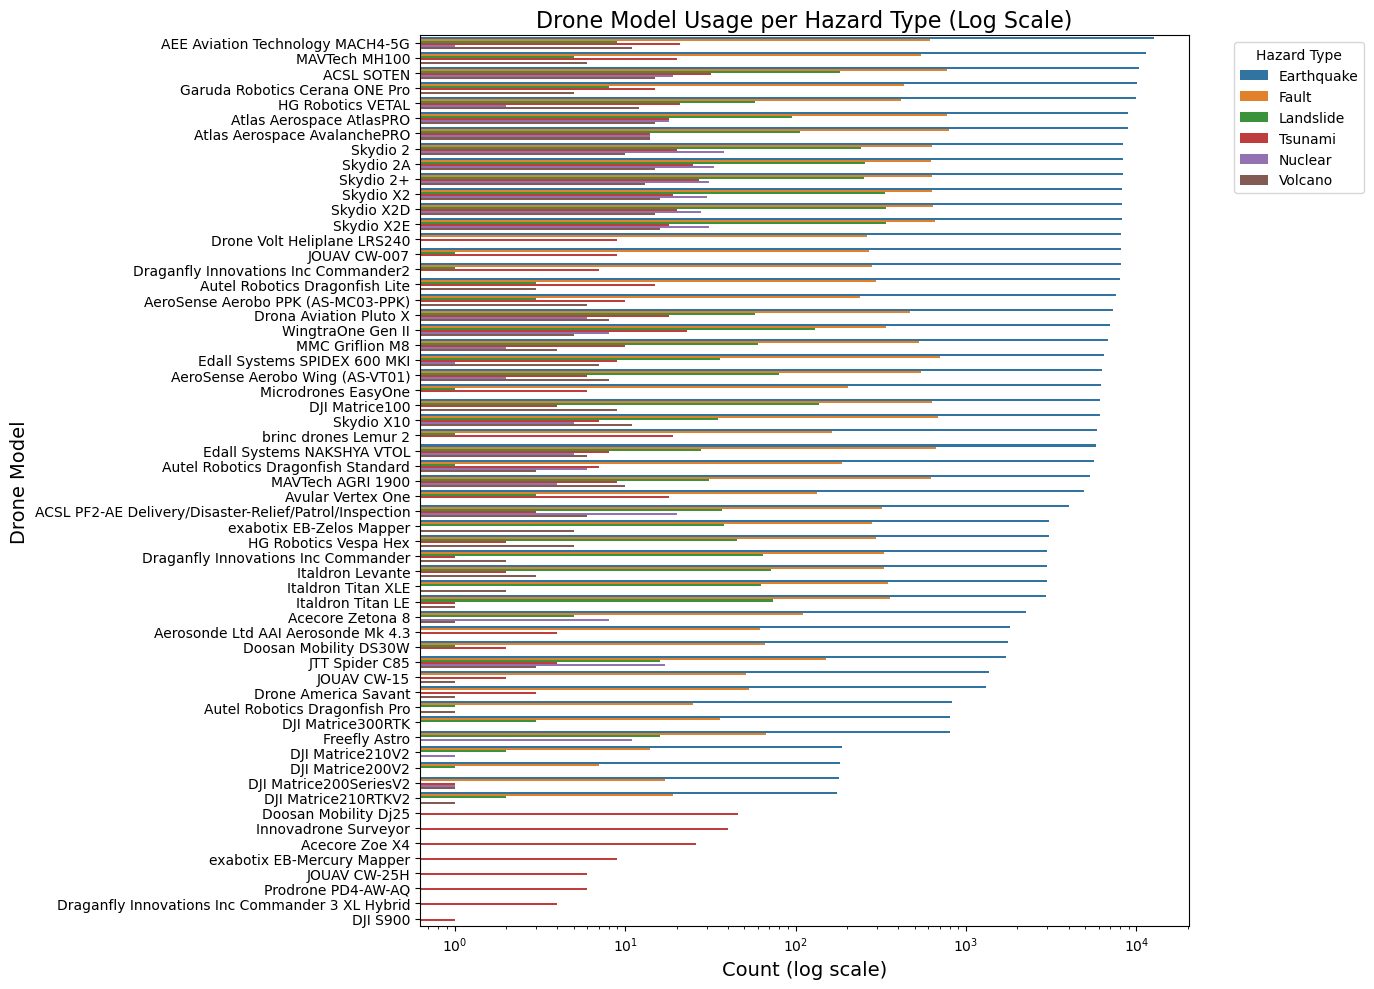

In [75]:
# Melt drone1, drone2, drone3 into one column
melted = final_df.melt(
    id_vars=['HazardType'],
    value_vars=['drone1', 'drone2', 'drone3'],
    var_name='drone_rank',
    value_name='drone_model'
)

# Clean strings (optional but recommended)
melted['HazardType'] = melted['HazardType'].str.strip()
melted['drone_model'] = melted['drone_model'].str.strip()

# Group and count
drone_hazard_counts = melted.groupby(['HazardType', 'drone_model']).size().reset_index(name='count')
drone_hazard_counts = drone_hazard_counts.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(data=drone_hazard_counts, x='count', y='drone_model', hue='HazardType')

# Log scale
plt.xscale('log')

# Labels and formatting
plt.title('Drone Model Usage per Hazard Type (Log Scale)', fontsize=16)
plt.xlabel('Count (log scale)', fontsize=14)
plt.ylabel('Drone Model', fontsize=14)
plt.legend(title='Hazard Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

----
# Drone Rotation included

In [89]:
drone_df.rename(columns={"model_name": "mfc_model"}, inplace=True)

In [90]:
def assign_best_drones_with_blacklist_batch(
    merged_df,
    drone_df,
    chunk_size=50000,
    save_dir=r"D:\NDIS_Database\FinalDroneAssignment",
    blacklist_threshold=20000
):
    os.makedirs(save_dir, exist_ok=True)

    # Clean drone_df
    drone_df = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    drone_df["drone_id"] = drone_df["mfc_model"]
    drone_df["comm_range"] = pd.to_numeric(drone_df["comm_range"], errors="coerce")
    drone_df["distance_range"] = pd.to_numeric(drone_df["distance_range"], errors="coerce")
    drone_df["max_payload_weight"] = pd.to_numeric(drone_df["max_payload_weight"], errors="coerce")

    usage_count = {model: 0 for model in drone_df["drone_id"].unique()}
    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f680 Processing chunk {start}-{end}")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        chunk[["drone1", "drone2", "drone3"]] = None
        chunk[["note1", "note2", "note3"]] = None

        for idx, row in tqdm(chunk.iterrows(), total=len(chunk)):
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            if pd.isna(s_weight):
                continue

            candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if candidates.empty:
                continue

            def score_drone(dr):
                score = 100
                note = ""

                if not pd.isna(h_dist):
                    if dr["comm_range"] < h_dist:
                        score += 50
                        note = "Comm range insufficient"

                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        score -= 5
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        score += 5
                        note = "2–3 swaths needed"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        score += 10
                        note = "Multiple passes"
                    else:
                        score += 30
                        note = "Very limited range"
                else:
                    note = "Distance unknown — likely offshore"
                    score += 20

                # Payload proximity
                payload_diff = dr["max_payload_weight"] - s_weight
                score += abs(payload_diff) * 0.05

                # Usage penalty
                uc = usage_count.get(dr["drone_id"], 0)
                if uc >= blacklist_threshold:
                    score += 9999  # Hard exclude
                else:
                    score += uc * 0.01  # Soft bias

                score += random.uniform(-0.5, 0.5)
                return pd.Series([score, note])

            candidates[["score", "note"]] = candidates.apply(score_drone, axis=1)
            candidates = candidates.sort_values("score").drop_duplicates("drone_id").head(10)

            assigned = []
            notes = []

            for _, dr in candidates.iterrows():
                if dr["drone_id"] not in assigned:
                    assigned.append(dr["drone_id"])
                    notes.append(dr["note"])
                if len(assigned) == 3:
                    break

            for i in range(len(assigned)):
                chunk.at[idx, f"drone{i+1}"] = assigned[i]
                chunk.at[idx, f"note{i+1}"] = notes[i]
                usage_count[assigned[i]] += 1

        # Save feather
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)

In [19]:
def heartbeat(interval=3600):
    while True:
        tqdm.write(f"⏳ Heartbeat: still running at {time.strftime('%Y-%m-%d %H:%M:%S')}")
        time.sleep(interval)

In [91]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = assign_best_drones_with_blacklist_batch(sample, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Heartbeat: still running at 2025-07-30 18:19:49
🚀 Processing chunk 0-50000


 17%|█▋        | 8453/50000 [11:00<36:30, 18.97it/s]   

⏳ Heartbeat: still running at 2025-07-30 18:30:50


 52%|█████▏    | 25901/50000 [26:16<24:20, 16.50it/s]  

⏳ Heartbeat: still running at 2025-07-30 18:46:06


 52%|█████▏    | 26014/50000 [26:33<26:56, 14.84it/s]  

⏳ Heartbeat: still running at 2025-07-30 18:46:23


 55%|█████▍    | 27439/50000 [28:33<28:25, 13.23it/s]  

⏳ Heartbeat: still running at 2025-07-30 18:48:23


 58%|█████▊    | 28813/50000 [30:01<20:33, 17.18it/s]  

⏳ Heartbeat: still running at 2025-07-30 18:49:50


 69%|██████▉   | 34735/50000 [37:52<14:59, 16.97it/s]  

⏳ Heartbeat: still running at 2025-07-30 18:57:41


 99%|█████████▉| 49669/50000 [52:21<00:18, 17.45it/s]  

⏳ Heartbeat: still running at 2025-07-30 19:12:11


100%|██████████| 50000/50000 [52:38<00:00, 15.83it/s]﻿


🚀 Processing chunk 50000-100000


  0%|          | 72/50000 [00:03<41:34, 20.01it/s] 

⏳ Heartbeat: still running at 2025-07-30 19:12:31


  1%|          | 321/50000 [00:17<39:30, 20.96it/s]  

⏳ Heartbeat: still running at 2025-07-30 19:12:46


 13%|█▎        | 6690/50000 [06:51<43:18, 16.67it/s]  

⏳ Heartbeat: still running at 2025-07-30 19:19:19


 14%|█▍        | 7001/50000 [07:21<1:08:37, 10.44it/s]

⏳ Heartbeat: still running at 2025-07-30 19:19:49


 39%|███▉      | 19478/50000 [18:22<24:17, 20.95it/s] 

⏳ Heartbeat: still running at 2025-07-30 19:30:50


 75%|███████▌  | 37508/50000 [33:38<10:44, 19.38it/s]

⏳ Heartbeat: still running at 2025-07-30 19:46:06


 76%|███████▌  | 37859/50000 [33:55<11:53, 17.02it/s]

⏳ Heartbeat: still running at 2025-07-30 19:46:23


 80%|████████  | 40222/50000 [35:55<07:33, 21.56it/s]

⏳ Heartbeat: still running at 2025-07-30 19:48:23


 84%|████████▍ | 41983/50000 [37:22<06:52, 19.43it/s]

⏳ Heartbeat: still running at 2025-07-30 19:49:50


100%|██████████| 50000/50000 [44:40<00:00, 18.65it/s]﻿


✅ All processing completed! Elapsed time: 97.33713045666615 minutes


In [92]:
# Assuming your result is in `final_df`
drone_counts = final_df[["drone1", "drone2", "drone3"]].stack().value_counts()

# Display top 10 most used drones
print(drone_counts.head(60))

⏳ Heartbeat: still running at 2025-07-30 19:57:41
AEE Aviation Technology MACH4-5G                          13346
MAVTech MH100                                             11938
ACSL SOTEN                                                11402
Garuda Robotics Cerana ONE Pro                            10474
HG Robotics VETAL                                         10440
Atlas Aerospace AvalanchePRO                               9903
Atlas Aerospace AtlasPRO                                   9901
Skydio 2                                                   9302
Skydio 2A                                                  9298
Skydio 2+                                                  9297
Skydio X2                                                  9234
Skydio X2E                                                 9232
Skydio X2D                                                 9231
Drone Volt Heliplane LRS240                                8388
Draganfly Innovations Inc Commander2                  

In [93]:
final_df.drone1.unique()

array(['ACSL SOTEN', 'Skydio X2E', 'Skydio X2',
       'Garuda Robotics Cerana ONE Pro', 'MMC Griflion M8',
       'AEE Aviation Technology MACH4-5G', 'DJI Matrice100',
       'Drone Volt Heliplane LRS240', 'Atlas Aerospace AtlasPRO',
       'Atlas Aerospace AvalanchePRO', 'AeroSense Aerobo Wing (AS-VT01)',
       'HG Robotics VETAL', 'Skydio X2D', 'MAVTech MH100', 'JOUAV CW-007',
       'Draganfly Innovations Inc Commander2', 'WingtraOne Gen II',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Autel Robotics Dragonfish Lite',
       'AeroSense Aerobo PPK (AS-MC03-PPK)', 'Skydio 2A',
       'Doosan Mobility Dj25', 'Skydio 2+', 'Skydio 2',
       'Edall Systems SPIDEX 600 MKI', 'Microdrones EasyOne',
       'Skydio X10', 'brinc drones Lemur 2', 'Drona Aviation Pluto X',
       'Autel Robotics Dragonfish Standard',
       'Edall Systems NAKSHYA VTOL ', 'MAVTech AGRI 1900',
       'Avular Vertex One', 'Italdron Titan XLE', 'Italdron Levante',
       'Italdron Tita

In [94]:
len(final_df.drone1.unique())

51

In [95]:
final_df.drone2.unique()

array(['Atlas Aerospace AtlasPRO', 'Skydio X2D',
       'Drone Volt Heliplane LRS240', 'Garuda Robotics Cerana ONE Pro',
       'MAVTech MH100', 'HG Robotics VETAL', 'MMC Griflion M8',
       'JOUAV CW-007', 'DJI Matrice100', 'Atlas Aerospace AvalanchePRO',
       'Draganfly Innovations Inc Commander2', 'WingtraOne Gen II',
       'Skydio X2E', 'ACSL SOTEN', 'AeroSense Aerobo Wing (AS-VT01)',
       'Autel Robotics Dragonfish Lite', 'Skydio X2', 'JTT Spider C85',
       'Skydio 2', 'Acecore Zetona 8', 'Skydio 2A', 'Skydio 2+',
       'AeroSense Aerobo PPK (AS-MC03-PPK)', 'exabotix EB-Mercury Mapper',
       'Innovadrone Surveyor', 'Autel Robotics Dragonfish Standard',
       'Edall Systems SPIDEX 600 MKI', 'Microdrones EasyOne',
       'Skydio X10', 'brinc drones Lemur 2',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Drona Aviation Pluto X', 'AEE Aviation Technology MACH4-5G',
       'Edall Systems NAKSHYA VTOL ', 'Acecore Zoe X4',
       'Italdron Levante',

In [99]:
len(final_df.drone2.unique())

53

In [96]:
final_df.drone3.unique()

array(['Atlas Aerospace AvalanchePRO', 'Skydio X2', 'Skydio X2E',
       'JOUAV CW-007', 'Autel Robotics Dragonfish Lite', 'ACSL SOTEN',
       'AeroSense Aerobo Wing (AS-VT01)',
       'Draganfly Innovations Inc Commander2', 'Skydio X2D',
       'AEE Aviation Technology MACH4-5G', 'Atlas Aerospace AtlasPRO',
       'MAVTech MH100', 'Drone Volt Heliplane LRS240', 'MMC Griflion M8',
       'HG Robotics VETAL', 'DJI Matrice100',
       'Garuda Robotics Cerana ONE Pro', 'Acecore Zetona 8', 'Skydio 2A',
       'Autel Robotics Dragonfish Standard', 'Skydio 2+', 'Skydio 2',
       'WingtraOne Gen II', 'AeroSense Aerobo PPK (AS-MC03-PPK)',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Skydio X10', 'Acecore Zoe X4', 'Freefly Astro',
       'exabotix EB-Mercury Mapper', 'Edall Systems SPIDEX 600 MKI',
       'Microdrones EasyOne', 'Innovadrone Surveyor',
       'brinc drones Lemur 2', 'JTT Spider C85', 'Drona Aviation Pluto X',
       'Prodrone PD4-AW-AQ', 'Edall Syst

In [97]:
len(final_df.drone3.unique())

57

In [5]:
dronesensor = pd.read_csv(r"D:\NDIS_Database\NDIS372_geohazard_drone_results.csv")
dronesensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   DroneModel                object 
 6   PayloadWeight             float64
 7   DistanceRange             int64  
 8   CommRange                 float64
 9   FlightTime                float64
 10  sensor_weight             int64  
 11  model                     object 
 12  source_sensor             object 
 13  country                   object 
 14  mtow                      float64
 15  length                    float64
 16  width                     float64
 17  height                    float64
 18  max_speed                 float64
 19  distance_range            float64
 20  max_payload_weight    

In [6]:
cols_to_drop = [
    'country',
    'length',
    'width',
    'height',
    'max_speed',
    'max_alt',
    'power_source',
    'price',
    'image',
    'source',
    'configuration_harmonized'
]

dronesensor = dronesensor.drop(columns=cols_to_drop)

In [7]:
dronesensor.Sensor.unique()

array(['Thermal Camera', 'Camera', 'LiDAR', 'Magnetometers', 'Seismic'],
      dtype=object)

In [15]:
sensor_df.sensor_name.unique()

array(['Seismic', 'Magnetometers', 'Electromagnetic', 'Gravimeter', 'GPR',
       'LiDAR', 'Camera', 'Hyperspectral', 'Multispectral',
       'Thermal Camera', 'Radar Altimeter', 'Gamma Spectrometer', 'BPR'],
      dtype=object)

In [16]:
drone_df.configuration.unique()

array(['0', '4', '6', '8', '2', '3', '5', 'fixed wing VTOL', 'X8',
       'fixedwing VTOL', 'fixed wing', nan, '5 fixed wing VTOL',
       'helicopter'], dtype=object)

In [24]:
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rpas_id                   179 non-null    int64  
 1   country                   179 non-null    object 
 2   manufacturer              179 non-null    object 
 3   mfc_model                 179 non-null    object 
 4   mtow                      157 non-null    float64
 5   length                    153 non-null    float64
 6   width                     160 non-null    float64
 7   height                    135 non-null    float64
 8   max_speed                 153 non-null    float64
 9   distance_range            70 non-null     float64
 10  flight_time               165 non-null    float64
 11  max_payload_weight        161 non-null    float64
 12  max_alt                   101 non-null    float64
 13  comm_range                118 non-null    float64
 14  power_sour

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998132 entries, 0 to 16998131
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
 8   distance           float64
 9   mission_distance   float64
 10  travel_time        float64
 11  monitor_time       float64
 12  setup_buffer       float64
 13  cpm_total_time     float64
 14  drone1             object 
 15  drone2             object 
 16  drone3             object 
 17  note1              object 
 18  note2              object 
 19  note3              object 
dtypes: float64(8), int64(2), object(10)
memory usage: 2.5+ GB


In [16]:
# Define the mapping
config_map = {
    '0': 'Fixed Wing',
    '2': 'Helicopter / Bicopter',
    '3': 'Tricopter',
    '4': 'Quadcopter',
    '6': 'Hexacopter',
    '8': 'Octocopter',
    '5': 'Fixed Wing VTOL',
    '5 fixed wing VTOL': 'Fixed Wing VTOL',
    'fixed wing VTOL': 'Fixed Wing VTOL',
    'fixedwing VTOL': 'Fixed Wing VTOL',
    'fixed wing': 'Fixed Wing',
    'helicopter': 'Helicopter / Bicopter',
    'X8': 'X8 (Hybrid Octo)'
}

# Apply the mapping
drone_df["configuration_harmonized"] = drone_df["configuration"].map(config_map)

In [10]:
# Standardize both fields for safe matching
dronesensor['DroneModel_clean'] = dronesensor['DroneModel'].str.strip().str.lower()
drone_df['mfc_model_clean'] = drone_df['mfc_model'].str.strip().str.lower()

In [20]:
# Step 1: Clean up and filter drone_df first to save memory
exclude_fields = [
    'rpas_id', 'reg', 'def_payload', 'purpose', 'flight_cont',
    'materials', 'min_op_temp', 'max_op_temp', 'power',
    'gps_accuracy', 'engine', 'oas', 'flight_time', 'configuration'
]

# Drop extra fields if they exist
drone_extra = drone_df.drop(columns=[col for col in exclude_fields if col in drone_df.columns])

# Step 2: Merge only needed columns to avoid memory bloating
dronesensor_df = dronesensor.merge(
    drone_extra[['mfc_model_clean', 'image']],  # merge only relevant fields
    left_on='DroneModel_clean',
    right_on='mfc_model_clean',
    how='left',
    copy=False
)

# Step 3: Patch missing images manually (lightweight fix)
manual_image_map = {
    'Dragandfly Innovations Inc Starling X.2': 'https://draganfly.com/wp-content/uploads/2023/07/Disaster-Response.webp',
    'Dragandfly Innovations Inc Heavy Lift Drone': 'https://candrone.com/cdn/shop/products/ScreenShot2022-06-03at11.55.59AM.png'
}
mask = dronesensor_df['image'].isna() & dronesensor_df['DroneModel'].isin(manual_image_map)
dronesensor_df.loc[mask, 'image'] = dronesensor_df.loc[mask, 'DroneModel'].map(manual_image_map)

# Step 4: Run garbage collection to clean up memory (recommended in ArcGIS Pro)
gc.collect()

# Optional: Save to disk or GDB/table
# dronesensor_df.to_feather(r"path_to\light_dronesensor.feather")  # very fast load/save

print("✅ Done. Remaining NaN images:", dronesensor_df['image'].isna().sum())

<class 'NameError'>: name 'dronesensor' is not defined

In [22]:
# Step 1: Clean up and filter drone_df first to save memory
exclude_fields = [
    'rpas_id', 'reg', 'def_payload', 'purpose', 'flight_cont',
    'materials', 'min_op_temp', 'max_op_temp', 'power',
    'gps_accuracy', 'engine', 'oas', 'flight_time', 'configuration'
]

# Drop extra fields if they exist
drone_extra = drone_df.drop(columns=[col for col in exclude_fields if col in drone_df.columns])

# Step 2: Merge only needed columns to avoid memory bloating
final_df = final_df.merge(
    drone_extra[['mfc_model', 'image']],  # merge only relevant fields
    left_on='DroneModel',
    right_on='mfc_model',
    how='left',
    copy=False
)

# Step 3: Patch missing images manually (lightweight fix)
manual_image_map = {
    'Dragandfly Innovations Inc Starling X.2': 'https://draganfly.com/wp-content/uploads/2023/07/Disaster-Response.webp',
    'Dragandfly Innovations Inc Heavy Lift Drone': 'https://candrone.com/cdn/shop/products/ScreenShot2022-06-03at11.55.59AM.png'
}
mask = dronesensor_df['image'].isna() & final_df['DroneModel'].isin(manual_image_map)
final_df.loc[mask, 'image'] = final_df.loc[mask, 'DroneModel'].map(manual_image_map)

# Step 4: Run garbage collection to clean up memory (recommended in ArcGIS Pro)
gc.collect()

# Optional: Save to disk or GDB/table
# dronesensor_df.to_feather(r"path_to\light_dronesensor.feather")  # very fast load/save

print("✅ Done. Remaining NaN images:", final_df['image'].isna().sum())

<class 'KeyError'>: 'DroneModel'

In [12]:
dronesensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   HazardID            int64  
 1   HazardType          object 
 2   Stage               object 
 3   Sensor              object 
 4   FlightPath_m        float64
 5   DroneModel          object 
 6   PayloadWeight       float64
 7   DistanceRange       int64  
 8   CommRange           float64
 9   FlightTime          float64
 10  sensor_weight       int64  
 11  model               object 
 12  source_sensor       object 
 13  mtow                float64
 14  distance_range      float64
 15  max_payload_weight  float64
 16  comm_range          float64
 17  DroneModel_clean    object 
 18  mfc_model_clean     object 
 19  image               object 
dtypes: float64(8), int64(3), object(9)
memory usage: 2.4+ GB


In [14]:
# Re-merge with selected non-excluded columns
columns_to_add = [
    'mfc_model_clean', 'country', 'manufacturer', 'mfc_model',
    'length', 'width', 'height', 'max_speed', 'max_alt',
    'power_source', 'price', 'image', 'source', 'configuration_harmonized'
]

# Filter out columns that don't exist in drone_df to avoid error
columns_to_add = [col for col in columns_to_add if col in drone_df.columns]

# Re-merge
dronesensor_df = dronesensor_df.drop(columns=[col for col in columns_to_add if col != 'mfc_model_clean'], errors='ignore')
dronesensor_df = dronesensor_df.merge(
    drone_df[columns_to_add],
    on='mfc_model_clean',
    how='left'
)

In [17]:
# Step 1: Ensure DroneModel_clean is lowercase and stripped
dronesensor_df["DroneModel_clean"] = dronesensor_df["DroneModel"].astype(str).str.strip().str.lower()

# Step 2: Prepare manual image mapping (lowercased keys)
manual_image_map = {
    "dragandfly innovations inc starling x.2": "https://draganfly.com/wp-content/uploads/2023/07/Disaster-Response.webp",
    "dragandfly innovations inc heavy lift drone": "https://candrone.com/cdn/shop/products/ScreenShot2022-06-03at11.55.59AM.png"
}

# Step 3: Create mapping Series
manual_map_series = pd.Series(manual_image_map)

# Step 4: Fill only rows with missing images using `.fillna()` and `.map()`
missing_mask = dronesensor_df["image"].isna()
dronesensor_df.loc[missing_mask, "image"] = (
    dronesensor_df.loc[missing_mask, "DroneModel_clean"].map(manual_map_series)
)


In [18]:
dronesensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 32 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   DroneModel                object 
 6   PayloadWeight             float64
 7   DistanceRange             int64  
 8   CommRange                 float64
 9   FlightTime                float64
 10  sensor_weight             int64  
 11  model                     object 
 12  source_sensor             object 
 13  mtow                      float64
 14  distance_range            float64
 15  max_payload_weight        float64
 16  comm_range                float64
 17  DroneModel_clean          object 
 18  mfc_model_clean           object 
 19  country                   object 
 20  manufacturer          

In [24]:
dronesensor_df.image.isna().unique()

array([False])

In [20]:
# Show DroneModel values where image is NaN after merge
missing_image_models = dronesensor_df[dronesensor_df['image'].isna()]['DroneModel'].unique()

print(f"🚨 DroneModels with missing image after merge ({len(missing_image_models)}):")
print(missing_image_models)

🚨 DroneModels with missing image after merge (0):
[]


In [46]:
# Mapping dictionary from Sensor column values to sensor_name values
sensor_mapping = {
    'Thermal_Camera': 'Thermal Camera',
    'Thermal_Camera': 'Thermal Camera',  # Ensure consistency for Thermal Camera
    'Camera': 'Camera',
    'Lidar': 'LiDAR',
    'Magnetometers': 'Magnetometers',
    'Seismic': 'Seismic'
}

# Standardize Sensor names in dronesensor_df
dronesensor['Sensor'] = dronesensor['Sensor'].map(sensor_mapping).fillna(dronesensor['Sensor'])

# List of fields to exclude from sensor_df
exclude_sensor = [
    'sensor_id', 'parameters_measured', 'method'
]

# Filter sensor_df to include only desired fields
sensor_extra = sensor_df.drop(columns=exclude_sensor)

# Merge the dataframes on the consistent sensor names
dronesensor = dronesensor.merge(
    sensor_extra,
    left_on='Sensor',
    right_on='sensor_name',
    how='left',
    suffixes=('', '_sensor')
)

# Check the resulting dataframe
dronesensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 31 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   DroneModel                object 
 6   PayloadWeight             float64
 7   DistanceRange             int64  
 8   CommRange                 float64
 9   FlightTime                float64
 10  country                   object 
 11  manufacturer              object 
 12  mfc_model                 object 
 13  length                    float64
 14  width                     float64
 15  height                    float64
 16  max_speed                 float64
 17  max_alt                   float64
 18  power_source              object 
 19  price                     float64
 20  image                 

In [48]:
# List of columns to exclude from dronesensor_df before merge
exclude_dronesensor_columns = [
    'sensor_name', 
    'sensor_weight', 
    'model', 
    'source_sensor', 
    'sensor_name_sensor', 
    'sensor_weight_sensor', 
    'model_sensor', 
    'source_sensor'
]

# Drop the unwanted columns from dronesensor_df
dronesensor_df = dronesensor.drop(columns=exclude_dronesensor_columns)

In [50]:
# List of fields to exclude from sensor_df
exclude_sensor = [
    'sensor_id', 'parameters_measured', 'method'
]

# Filter sensor_df to include only desired fields
sensor_extra = sensor_df.drop(columns=exclude_sensor)

# Merge
dronesensor_df = dronesensor_df.merge(
    sensor_extra,
    left_on='Sensor',
    right_on='sensor_name',
    how='left',
    suffixes=('', '_sensor')
)
dronesensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   DroneModel                object 
 6   PayloadWeight             float64
 7   DistanceRange             int64  
 8   CommRange                 float64
 9   FlightTime                float64
 10  country                   object 
 11  manufacturer              object 
 12  mfc_model                 object 
 13  length                    float64
 14  width                     float64
 15  height                    float64
 16  max_speed                 float64
 17  max_alt                   float64
 18  power_source              object 
 19  price                     float64
 20  image                 

In [21]:
dronesensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 32 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   DroneModel                object 
 6   PayloadWeight             float64
 7   DistanceRange             int64  
 8   CommRange                 float64
 9   FlightTime                float64
 10  sensor_weight             int64  
 11  model                     object 
 12  source_sensor             object 
 13  mtow                      float64
 14  distance_range            float64
 15  max_payload_weight        float64
 16  comm_range                float64
 17  DroneModel_clean          object 
 18  mfc_model_clean           object 
 19  country                   object 
 20  manufacturer          

In [22]:
cols_to_drop = [
    "DroneModel",
    "mfc_model",
    "mfc_model_clean",
    "manufacturer"
]

dronesensor_df = dronesensor_df.drop(columns=cols_to_drop)
dronesensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16346160 entries, 0 to 16346159
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   HazardID                  int64  
 1   HazardType                object 
 2   Stage                     object 
 3   Sensor                    object 
 4   FlightPath_m              float64
 5   PayloadWeight             float64
 6   DistanceRange             int64  
 7   CommRange                 float64
 8   FlightTime                float64
 9   sensor_weight             int64  
 10  model                     object 
 11  source_sensor             object 
 12  mtow                      float64
 13  distance_range            float64
 14  max_payload_weight        float64
 15  comm_range                float64
 16  DroneModel_clean          object 
 17  country                   object 
 18  length                    float64
 19  width                     float64
 20  height                

In [14]:
cols_to_drop = [
    "DroneRank",
    "PayloadOverkill",
    "DistanceOverkill",
    "mtow",
    "distance_range",
    "max_payload_weight",
    "comm_range"
]

dronesensor_df = dronesensor_df.drop(columns=cols_to_drop)

In [23]:
dronesensor_df.to_csv(r"D:\NDIS_Database\07_RPAS\NDIS372_geohazard_drone_results2.csv", index=False)

----
# SD ver 3.8.3
----

In [5]:
def heartbeat(interval=3600):
    while True:
        tqdm.write(f"⏳ Heartbeat: still running at {time.strftime('%Y-%m-%d %H:%M:%S')}")
        time.sleep(interval)

In [18]:
def assign_best_drones_with_blacklist_batch(
    merged_df,
    drone_df,
    chunk_size=50000,
    save_dir=r"D:\NDIS_Database\FinalDroneAssignment",
    blacklist_threshold=20000
):
    os.makedirs(save_dir, exist_ok=True)

    # Clean drone_df
    drone_df = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    drone_df["drone_id"] = drone_df["mfc_model"]
    drone_df["comm_range"] = pd.to_numeric(drone_df["comm_range"], errors="coerce")
    drone_df["distance_range"] = pd.to_numeric(drone_df["distance_range"], errors="coerce")
    drone_df["max_payload_weight"] = pd.to_numeric(drone_df["max_payload_weight"], errors="coerce")

    usage_count = {model: 0 for model in drone_df["drone_id"].unique()}
    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f680 Processing chunk {start}-{end}")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        chunk[["drone1", "drone2", "drone3"]] = None
        chunk[["note1", "note2", "note3"]] = None

        for idx, row in tqdm(chunk.iterrows(), total=len(chunk)):
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["RecommendedSensor"]

            if pd.isna(s_weight):
                continue

            candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if candidates.empty:
                continue

            def score_drone(dr):
                score = 100
                note = ""

                if not pd.isna(h_dist):
                    if dr["comm_range"] < h_dist:
                        score += 50
                        note = "Comm range insufficient"

                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        score -= 5
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        score += 5
                        note = "2–3 swaths needed"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        score += 10
                        note = "Multiple passes"
                    else:
                        score += 30
                        note = "Very limited range"
                else:
                    note = "Distance unknown — likely offshore"
                    score += 20

                # Payload proximity
                payload_diff = dr["max_payload_weight"] - s_weight
                score += abs(payload_diff) * 0.05

                # Usage penalty
                uc = usage_count.get(dr["drone_id"], 0)
                if uc >= blacklist_threshold:
                    score += 9999  # Hard exclude
                else:
                    score += uc * 0.01  # Soft bias

                score += random.uniform(-0.5, 0.5)
                return pd.Series([score, note])

            candidates[["score", "note"]] = candidates.apply(score_drone, axis=1)
            candidates = candidates.sort_values("score").drop_duplicates("drone_id").head(10)

            assigned = []
            notes = []

            for _, dr in candidates.iterrows():
                if dr["drone_id"] not in assigned:
                    assigned.append(dr["drone_id"])
                    notes.append(dr["note"])
                if len(assigned) == 3:
                    break

            for i in range(len(assigned)):
                chunk.at[idx, f"drone{i+1}"] = assigned[i]
                chunk.at[idx, f"note{i+1}"] = notes[i]
                usage_count[assigned[i]] += 1

        # Save feather
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)

In [20]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = assign_best_drones_with_blacklist_batch(sample, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

🚀 Processing chunk 0-50000
⏳ Heartbeat: still running at 2025-08-01 23:12:53


100%|██████████| 50000/50000 [39:09<00:00, 21.28it/s] ﻿


🚀 Processing chunk 50000-100000


﻿                                                    ﻿

⏳ Heartbeat: still running at 2025-08-02 00:12:53


100%|██████████| 50000/50000 [36:22<00:00, 22.91it/s]﻿


✅ All processing completed! Elapsed time: 75.55663286166576 minutes


In [7]:
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             179 non-null    int64  
 1   country             179 non-null    object 
 2   manufacturer        179 non-null    object 
 3   mfc_model           179 non-null    object 
 4   mtow                157 non-null    float64
 5   length              153 non-null    float64
 6   width               160 non-null    float64
 7   height              135 non-null    float64
 8   max_speed           154 non-null    float64
 9   distance_range      71 non-null     float64
 10  flight_time         165 non-null    float64
 11  max_payload_weight  161 non-null    float64
 12  max_alt             102 non-null    float64
 13  comm_range          118 non-null    float64
 14  power_source        163 non-null    object 
 15  power               111 non-null    object 
 16  gps_accu

In [3]:
save_dir = r"D:\NDIS_Database\FinalDroneAssignment"

# List all feather files in the save directory
feather_files = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith(".feather")]

# Read and concatenate all feather chunks
all_chunks = [pd.read_feather(fp) for fp in sorted(feather_files)]
final_df = pd.concat(all_chunks, ignore_index=True)

# Now `final_df` contains the full output
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   HazardID           100000 non-null  int64  
 1   HazardType         100000 non-null  object 
 2   latitude           100000 non-null  float64
 3   longitude          100000 non-null  float64
 4   DisasterPhase      100000 non-null  object 
 5   RecommendedSensor  100000 non-null  object 
 6   sensor_weight      100000 non-null  int64  
 7   sensor_model       100000 non-null  object 
 8   distance           94067 non-null   float64
 9   mission_distance   100000 non-null  float64
 10  travel_time        94067 non-null   float64
 11  monitor_time       100000 non-null  float64
 12  setup_buffer       100000 non-null  float64
 13  cpm_total_time     94067 non-null   float64
 14  drone1             100000 non-null  object 
 15  drone2             100000 non-null  object 
 16  dro

In [16]:
len(final_df.drone3.unique())

56

In [30]:
def assign_best_drones_with_hybrid_penalty(
    merged_df,
    drone_df,
    chunk_size=50000,
    save_dir=r"D:\NDIS_Database\FinalDroneAssignment",
    global_penalty=0.001,
    category_penalty=0.01
):
    os.makedirs(save_dir, exist_ok=True)

    # Clean drone_df
    drone_df = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    drone_df["drone_id"] = drone_df["mfc_model"]
    drone_df["comm_range"] = pd.to_numeric(drone_df["comm_range"], errors="coerce")
    drone_df["distance_range"] = pd.to_numeric(drone_df["distance_range"], errors="coerce")
    drone_df["max_payload_weight"] = pd.to_numeric(drone_df["max_payload_weight"], errors="coerce")

    # Initialize usage tracking
    global_usage_count = {model: 0 for model in drone_df["drone_id"].unique()}
    usage_by_category = {}

    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f680 Processing chunk {start}-{end}")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        chunk[["drone1", "drone2", "drone3"]] = None
        chunk[["note1", "note2", "note3"]] = None

        for idx, row in tqdm(chunk.iterrows(), total=len(chunk)):
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row["sensor_model"] if "sensor_model" in row else row["RecommendedSensor"]
            hazard = row.get("HazardType", "Unknown")

            if pd.isna(s_weight):
                continue

            candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if candidates.empty:
                continue

            def score_drone(dr):
                score = 100
                note = ""

                if not pd.isna(h_dist):
                    if dr["comm_range"] < h_dist:
                        score += 50
                        note = "Comm range insufficient"

                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        score -= 5
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        score += 5
                        note = "2–3 swaths needed"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        score += 10
                        note = "Multiple passes"
                    else:
                        score += 30
                        note = "Very limited range"
                else:
                    note = "Distance unknown — likely offshore"
                    score += 20

                # Payload proximity
                payload_diff = dr["max_payload_weight"] - s_weight
                score += abs(payload_diff) * 0.05

                # Hybrid penalty
                drone_id = dr["drone_id"]
                cat_key = (hazard, sensor, drone_id)

                g_usage = global_usage_count.get(drone_id, 0)
                c_usage = usage_by_category.get(cat_key, 0)

                score += g_usage * global_penalty
                score += c_usage * category_penalty

                score += random.uniform(-0.5, 0.5)
                return pd.Series([score, note])

            candidates[["score", "note"]] = candidates.apply(score_drone, axis=1)
            candidates = candidates.sort_values("score").drop_duplicates("drone_id").head(10)

            assigned = []
            notes = []

            for _, dr in candidates.iterrows():
                if dr["drone_id"] not in assigned:
                    assigned.append(dr["drone_id"])
                    notes.append(dr["note"])
                if len(assigned) == 3:
                    break

            for i in range(len(assigned)):
                chunk.at[idx, f"drone{i+1}"] = assigned[i]
                chunk.at[idx, f"note{i+1}"] = notes[i]
                drone_id = assigned[i]
                cat_key = (hazard, sensor, drone_id)

                global_usage_count[drone_id] += 1
                usage_by_category[cat_key] = usage_by_category.get(cat_key, 0) + 1

        # Save feather
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True)

In [19]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

final_df = assign_best_drones_with_hybrid_penalty(sample, drone_df, chunk_size=50000)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

🚀 Processing chunk 0-50000
⏳ Heartbeat: still running at 2025-08-07 13:48:25


100%|██████████| 50000/50000 [57:30<00:00, 14.49it/s]  ﻿


✅ All processing completed! Elapsed time: 57.51668038499968 minutes


In [26]:
final_df.drone3.unique()

array(['Atlas Aerospace AtlasPRO', 'Skydio X2E', 'Skydio X2',
       'Draganfly Innovations Inc Commander2',
       'Autel Robotics Dragonfish Lite', 'Drone Volt Heliplane LRS240',
       'ACSL SOTEN', 'JOUAV CW-007', 'MMC Griflion M8', 'Skydio X2D',
       'AEE Aviation Technology MACH4-5G', 'MAVTech MH100',
       'DJI Matrice100', 'HG Robotics VETAL',
       'Garuda Robotics Cerana ONE Pro', 'Atlas Aerospace AvalanchePRO',
       'AeroSense Aerobo Wing (AS-VT01)',
       'Autel Robotics Dragonfish Standard', 'Skydio 2', 'JTT Spider C85',
       'Skydio 2+', 'AeroSense Aerobo PPK (AS-MC03-PPK)',
       'exabotix EB-Mercury Mapper', 'WingtraOne Gen II',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Freefly Astro', 'Acecore Zoe X4', 'Acecore Zetona 8',
       'Skydio X10', 'JOUAV CW-25H', 'Microdrones EasyOne',
       'Innovadrone Surveyor', 'Prodrone PD4-AW-AQ',
       'Drona Aviation Pluto X', 'exabotix EB-Zelos Mapper',
       'HG Robotics Vespa Hex', 'Ita

In [6]:
def assign_best_drones_with_hybrid_penalty(
    merged_df,
    drone_df,
    chunk_size=50000,
    save_dir=r"D:\NDIS_Database\20_PaperSimulation\FinalDroneAssignment",
    global_penalty=0.001,
    category_penalty=0.01
):
    os.makedirs(save_dir, exist_ok=True)

    # Clean drone_df
    drone_df = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    drone_df["drone_id"] = drone_df["mfc_model"]
    drone_df["comm_range"] = pd.to_numeric(drone_df["comm_range"], errors="coerce")
    drone_df["distance_range"] = pd.to_numeric(drone_df["distance_range"], errors="coerce")
    drone_df["max_payload_weight"] = pd.to_numeric(drone_df["max_payload_weight"], errors="coerce")

    # Usage trackers
    global_usage_count = {model: 0 for model in drone_df["drone_id"].unique()}
    usage_by_category = {}

    all_results = []

    for start in range(0, len(merged_df), chunk_size):
        end = min(start + chunk_size, len(merged_df))
        chunk = merged_df.iloc[start:end].copy()
        print(f"\U0001f680 Processing chunk {start}-{end}")

        chunk["distance"] = pd.to_numeric(chunk["distance"], errors="coerce")
        chunk["mission_distance"] = pd.to_numeric(chunk["mission_distance"], errors="coerce")
        chunk["sensor_weight"] = pd.to_numeric(chunk["sensor_weight"], errors="coerce")

        chunk[["drone1", "drone2", "drone3"]] = None
        chunk[["note1", "note2", "note3"]] = None

        for idx, row in tqdm(chunk.iterrows(), total=len(chunk)):
            s_weight = row["sensor_weight"]
            h_dist = row["distance"]
            m_dist = row["mission_distance"]
            sensor = row.get("sensor_model") or row.get("RecommendedSensor")
            hazard = row.get("HazardType", "Unknown")

            if pd.isna(s_weight):
                continue

            candidates = drone_df[drone_df["max_payload_weight"] >= s_weight].copy()
            if candidates.empty:
                continue

            def score_drone(dr):
                score = 100
                note = ""

                # Comm range penalty
                if not pd.isna(h_dist) and dr["comm_range"] < h_dist:
                    score += 30
                    note = "Comm range insufficient"

                # Mission distance penalty
                if not pd.isna(m_dist):
                    if dr["distance_range"] >= m_dist:
                        score -= 10
                        note = "Full coverage"
                    elif dr["distance_range"] >= 0.75 * m_dist:
                        score += 2
                        note = "Near full coverage"
                    elif dr["distance_range"] >= 0.5 * m_dist:
                        score += 5
                        note = "2–3 swaths needed"
                    elif dr["distance_range"] >= 0.25 * m_dist:
                        score += 15
                        note = "Multiple passes"
                    else:
                        score += 25
                        note = "Very limited range"
                else:
                    score += 10
                    note = "Distance unknown"

                # Payload proximity penalty (mild)
                payload_diff = dr["max_payload_weight"] - s_weight
                score += min(abs(payload_diff) * 0.01, 10)

                # Hybrid penalties
                drone_id = dr["drone_id"]
                cat_key = (hazard, sensor, drone_id)
                g_usage = global_usage_count.get(drone_id, 0)
                c_usage = usage_by_category.get(cat_key, 0)
                score += g_usage * global_penalty
                score += c_usage * category_penalty

                score += random.uniform(-0.25, 0.25)
                return pd.Series([score, note])

            candidates[["score", "note"]] = candidates.apply(score_drone, axis=1)
            candidates = candidates.sort_values("score").drop_duplicates("drone_id").head(10)



            assigned = []
            notes = []

            for _, dr in candidates.iterrows():
                if dr["drone_id"] not in assigned:
                    assigned.append(dr["drone_id"])
                    notes.append(dr["note"])
                if len(assigned) == 3:
                    break

            for i in range(len(assigned)):
                chunk.at[idx, f"drone{i+1}"] = assigned[i]
                chunk.at[idx, f"note{i+1}"] = notes[i]
                drone_id = assigned[i]
                cat_key = (hazard, sensor, drone_id)
                global_usage_count[drone_id] += 1
                usage_by_category[cat_key] = usage_by_category.get(cat_key, 0) + 1

        # Save feather
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_path)
        all_results.append(chunk)
        gc.collect()

    return pd.concat(all_results, ignore_index=True), global_usage_count, usage_by_category

In [ ]:
# Start the background heartbeat thread
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

# Run the main process with timer
start_time = timeit.default_timer()

result_df, global_usage_count, usage_by_category = assign_best_drones_with_hybrid_penalty(
    merged_df=ghz_with_cpm,
    drone_df=drone_df,
    chunk_size=50000
)

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

⏳ Heartbeat: still running at 2025-08-11 13:41:58
🚀 Processing chunk 0-50000


100%|██████████| 50000/50000 [54:57<00:00, 15.16it/s]  ﻿


🚀 Processing chunk 50000-100000


﻿                                                     ﻿

⏳ Heartbeat: still running at 2025-08-11 14:41:58


100%|██████████| 50000/50000 [49:37<00:00, 16.80it/s]  ﻿


🚀 Processing chunk 100000-150000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 15:41:58


100%|██████████| 50000/50000 [54:29<00:00, 15.29it/s]  ﻿


🚀 Processing chunk 150000-200000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 16:41:58


100%|██████████| 50000/50000 [48:51<00:00, 17.06it/s]  ﻿


🚀 Processing chunk 200000-250000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 17:41:58


100%|██████████| 50000/50000 [54:52<00:00, 15.19it/s]  ﻿


🚀 Processing chunk 250000-300000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 18:41:58


100%|██████████| 50000/50000 [1:03:30<00:00, 13.12it/s]﻿


🚀 Processing chunk 300000-350000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 19:41:58


100%|██████████| 50000/50000 [55:18<00:00, 15.07it/s]  ﻿


🚀 Processing chunk 350000-400000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 20:41:58


100%|██████████| 50000/50000 [53:25<00:00, 15.60it/s]﻿


🚀 Processing chunk 400000-450000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 21:41:58


100%|██████████| 50000/50000 [54:12<00:00, 15.37it/s]﻿


🚀 Processing chunk 450000-500000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 22:41:58


100%|██████████| 50000/50000 [56:04<00:00, 14.86it/s]﻿


🚀 Processing chunk 500000-550000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-11 23:41:58


100%|██████████| 50000/50000 [1:01:54<00:00, 13.46it/s]﻿


🚀 Processing chunk 550000-600000


100%|██████████| 50000/50000 [51:51<00:00, 16.07it/s]  ﻿


🚀 Processing chunk 600000-650000


﻿                                                    ﻿

⏳ Heartbeat: still running at 2025-08-12 00:41:58


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 01:41:58


100%|██████████| 50000/50000 [1:06:22<00:00, 12.55it/s]﻿


🚀 Processing chunk 650000-700000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 02:41:58


100%|██████████| 50000/50000 [1:02:21<00:00, 13.37it/s]﻿


🚀 Processing chunk 700000-750000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 03:41:58


100%|██████████| 50000/50000 [52:53<00:00, 15.76it/s]﻿


🚀 Processing chunk 750000-800000


100%|██████████| 50000/50000 [41:58<00:00, 19.85it/s]  ﻿


🚀 Processing chunk 800000-850000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 04:41:58


100%|██████████| 50000/50000 [40:52<00:00, 20.39it/s]﻿


🚀 Processing chunk 850000-900000


﻿                                                     ﻿

⏳ Heartbeat: still running at 2025-08-12 05:41:58


100%|██████████| 50000/50000 [40:20<00:00, 20.66it/s]﻿


🚀 Processing chunk 900000-950000


100%|██████████| 50000/50000 [40:31<00:00, 20.56it/s] ﻿


🚀 Processing chunk 950000-1000000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 06:41:58


100%|██████████| 50000/50000 [39:58<00:00, 20.85it/s]﻿


🚀 Processing chunk 1000000-1050000


﻿                                                     ﻿

⏳ Heartbeat: still running at 2025-08-12 07:41:58


100%|██████████| 50000/50000 [40:07<00:00, 20.77it/s]﻿


🚀 Processing chunk 1050000-1100000


100%|██████████| 50000/50000 [40:08<00:00, 20.76it/s]  ﻿


🚀 Processing chunk 1100000-1150000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 08:41:58


100%|██████████| 50000/50000 [40:55<00:00, 20.36it/s]﻿


🚀 Processing chunk 1150000-1200000


﻿                                                     ﻿

⏳ Heartbeat: still running at 2025-08-12 09:41:58


100%|██████████| 50000/50000 [40:33<00:00, 20.55it/s]﻿


🚀 Processing chunk 1200000-1250000


100%|██████████| 50000/50000 [40:26<00:00, 20.61it/s] ﻿


🚀 Processing chunk 1250000-1300000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 10:41:58


100%|██████████| 50000/50000 [42:25<00:00, 19.64it/s]﻿


🚀 Processing chunk 1300000-1350000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 11:41:58


100%|██████████| 50000/50000 [1:03:14<00:00, 13.18it/s]﻿


🚀 Processing chunk 1350000-1400000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 12:41:58


100%|██████████| 50000/50000 [58:36<00:00, 14.22it/s]  ﻿


🚀 Processing chunk 1400000-1450000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 13:41:58


100%|██████████| 50000/50000 [1:05:39<00:00, 12.69it/s]﻿


🚀 Processing chunk 1450000-1500000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 14:41:58


100%|██████████| 50000/50000 [46:06<00:00, 18.07it/s]﻿


🚀 Processing chunk 1500000-1550000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 15:41:58


100%|██████████| 50000/50000 [45:12<00:00, 18.43it/s]﻿


🚀 Processing chunk 1550000-1600000


100%|██████████| 50000/50000 [45:14<00:00, 18.42it/s]  ﻿


🚀 Processing chunk 1600000-1650000


﻿                                                     ﻿

⏳ Heartbeat: still running at 2025-08-12 16:41:58


100%|██████████| 50000/50000 [45:22<00:00, 18.36it/s]  ﻿


🚀 Processing chunk 1650000-1700000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 17:41:58


100%|██████████| 50000/50000 [48:34<00:00, 17.15it/s]  ﻿


🚀 Processing chunk 1700000-1750000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 18:41:58


100%|██████████| 50000/50000 [55:33<00:00, 15.00it/s]﻿


🚀 Processing chunk 1750000-1800000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 19:41:58


100%|██████████| 50000/50000 [57:05<00:00, 14.60it/s]﻿


🚀 Processing chunk 1800000-1850000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 20:41:58


100%|██████████| 50000/50000 [1:11:57<00:00, 11.58it/s]﻿


🚀 Processing chunk 1850000-1900000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 21:41:58


100%|██████████| 50000/50000 [1:08:36<00:00, 12.15it/s]﻿


🚀 Processing chunk 1900000-1950000


﻿                                                       ﻿

⏳ Heartbeat: still running at 2025-08-12 22:41:58


100%|██████████| 50000/50000 [1:00:03<00:00, 13.88it/s]﻿


🚀 Processing chunk 1950000-2000000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-12 23:41:58


100%|██████████| 50000/50000 [48:47<00:00, 17.08it/s]  ﻿


🚀 Processing chunk 2000000-2050000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-13 00:41:58


100%|██████████| 50000/50000 [45:11<00:00, 18.44it/s]﻿


🚀 Processing chunk 2050000-2100000


﻿                                                      ﻿

⏳ Heartbeat: still running at 2025-08-13 01:41:58


100%|██████████| 50000/50000 [45:34<00:00, 18.29it/s]﻿


🚀 Processing chunk 2100000-2150000


100%|██████████| 50000/50000 [45:35<00:00, 18.28it/s]  ﻿


🚀 Processing chunk 2150000-2200000


 30%|███       | 15041/50000 [13:39<30:08, 19.33it/s]  

In [45]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HazardID           50000 non-null  int64  
 1   HazardType         50000 non-null  object 
 2   latitude           50000 non-null  float64
 3   longitude          50000 non-null  float64
 4   DisasterPhase      50000 non-null  object 
 5   RecommendedSensor  50000 non-null  object 
 6   sensor_weight      50000 non-null  int64  
 7   sensor_model       50000 non-null  object 
 8   distance           47042 non-null  float64
 9   mission_distance   50000 non-null  float64
 10  travel_time        47042 non-null  float64
 11  monitor_time       50000 non-null  float64
 12  setup_buffer       50000 non-null  float64
 13  cpm_total_time     47042 non-null  float64
 14  drone1             50000 non-null  object 
 15  drone2             50000 non-null  object 
 16  drone3             500

In [11]:
len(final_df.drone2.unique())

77

In [7]:
# --- 1) Helper: rebuild usage + detect finished chunks ---
import os, glob
import pandas as pd
from collections import defaultdict

def rebuild_usage_from_saved(save_dir):
    global_usage_count = defaultdict(int)
    usage_by_category = defaultdict(int)
    done_ranges = set()

    pattern = os.path.join(save_dir, "drone_assign_chunk_*_*.feather")
    for fp in sorted(glob.glob(pattern)):
        base = os.path.basename(fp)
        try:
            _, s, e = base.replace(".feather", "").split("_")[-3:]
            start_i, end_i = int(s), int(e)
            done_ranges.add((start_i, end_i))
        except Exception:
            pass

        df = pd.read_feather(fp)
        sensor_col = "sensor_model" if "sensor_model" in df.columns else ("RecommendedSensor" if "RecommendedSensor" in df.columns else None)
        sens = df[sensor_col] if sensor_col else pd.Series(["Unknown"] * len(df))
        haz  = df["HazardType"] if "HazardType" in df.columns else pd.Series(["Unknown"] * len(df))

        for k in (1, 2, 3):
            dcol = f"drone{k}"
            if dcol not in df.columns: 
                continue
            mask = df[dcol].notna()
            if not mask.any(): 
                continue
            sub = df.loc[mask, [dcol]].copy()
            sub_h = haz.loc[mask]
            sub_s = sens.loc[mask]
            for h, s, d in zip(sub_h, sub_s, sub[dcol]):
                d_id = str(d)
                global_usage_count[d_id] += 1
                usage_by_category[(h if pd.notna(h) else "Unknown",
                                   s if pd.notna(s) else "Unknown",
                                   d_id)] += 1

    return dict(global_usage_count), dict(usage_by_category), done_ranges


# --- 2) Faster + resumable assigner (hybrid penalties, vectorized scoring) ---
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm

def assign_best_drones_with_hybrid_penalty_resumable(
    merged_df,
    drone_df,
    chunk_size=50_000,
    save_dir=r"D:\NDIS_Database\20_PaperSimulation\FinalDroneAssignment",
    global_penalty=0.001,
    category_penalty=0.01,
    resume=True,
    return_results=False
):
    os.makedirs(save_dir, exist_ok=True)

    ddf = drone_df.dropna(subset=["mfc_model", "max_payload_weight"]).copy()
    ddf = ddf.assign(
        drone_id = ddf["mfc_model"].astype(str),
        comm_range = pd.to_numeric(ddf["comm_range"], errors="coerce"),
        distance_range = pd.to_numeric(ddf["distance_range"], errors="coerce"),
        max_payload_weight = pd.to_numeric(ddf["max_payload_weight"], errors="coerce"),
    )
    d_ids   = ddf["drone_id"].to_numpy()
    d_comm  = ddf["comm_range"].to_numpy()
    d_dist  = ddf["distance_range"].to_numpy()
    d_pay   = ddf["max_payload_weight"].to_numpy()

    if resume:
        global_usage_count, usage_by_category, done_ranges = rebuild_usage_from_saved(save_dir)
    else:
        global_usage_count, usage_by_category, done_ranges = {}, {}, set()

    all_results = []
    n = len(merged_df)

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)

        if (start, end) in done_ranges:
            print(f"⏭️  Skipping chunk {start}-{end} (already saved)")
            continue

        print(f"🚀 Processing chunk {start}-{end}")
        chunk = merged_df.iloc[start:end].copy()

        h_dist_col   = pd.to_numeric(chunk["distance"], errors="coerce") if "distance" in chunk.columns else pd.Series(np.nan, index=chunk.index)
        m_dist_col   = pd.to_numeric(chunk["mission_distance"], errors="coerce") if "mission_distance" in chunk.columns else pd.Series(np.nan, index=chunk.index)
        s_weight_col = pd.to_numeric(chunk["sensor_weight"], errors="coerce") if "sensor_weight" in chunk.columns else pd.Series(np.nan, index=chunk.index)

        for k in (1,2,3):
            chunk[f"drone{k}"] = None
            chunk[f"note{k}"]  = None

        it = tqdm(list(chunk.itertuples(index=True, name=None)), total=len(chunk))
        for tup in it:
            idx = tup[0]
            s_weight = s_weight_col.at[idx]
            if pd.isna(s_weight):
                continue

            h_dist = h_dist_col.at[idx]
            m_dist = m_dist_col.at[idx]
            sensor = (chunk.at[idx, "sensor_model"]
                      if "sensor_model" in chunk.columns and pd.notna(chunk.at[idx, "sensor_model"])
                      else chunk.at[idx, "RecommendedSensor"]
                      if "RecommendedSensor" in chunk.columns and pd.notna(chunk.at[idx, "RecommendedSensor"])
                      else "Unknown")
            hazard = chunk.at[idx, "HazardType"] if "HazardType" in chunk.columns and pd.notna(chunk.at[idx, "HazardType"]) else "Unknown"

            mask = d_pay >= s_weight
            if not mask.any():
                continue

            cand_ids  = d_ids[mask]
            cand_comm = d_comm[mask]
            cand_dist = d_dist[mask]
            cand_pay  = d_pay[mask]

            scores = np.full(cand_ids.shape[0], 100.0)
            notes  = np.empty(cand_ids.shape[0], dtype=object); notes[:] = ""

            if pd.notna(h_dist):
                comm_bad = cand_comm < h_dist
                scores[comm_bad] += 30.0
                notes[comm_bad] = "Comm range insufficient"

            if pd.notna(m_dist):
                full      = cand_dist >= m_dist
                near_full = (~full) & (cand_dist >= 0.75*m_dist)
                half      = (~full) & (~near_full) & (cand_dist >= 0.50*m_dist)
                quarter   = (~full) & (~near_full) & (~half) & (cand_dist >= 0.25*m_dist)
                very_low  = (~full) & (~near_full) & (~half) & (~quarter)

                scores[full]      -= 10.0; notes[full]      = "Full coverage"
                scores[near_full] +=  2.0; notes[near_full] = "Near full coverage"
                scores[half]      +=  5.0; notes[half]      = "2–3 swaths needed"
                scores[quarter]   += 15.0; notes[quarter]   = "Multiple passes"
                scores[very_low]  += 25.0; notes[very_low]  = "Very limited range"
            else:
                scores += 10.0; notes[:] = "Distance unknown"

            payload_diff = np.abs(cand_pay - s_weight)
            scores += np.minimum(payload_diff * 0.01, 10.0)

            g_vec = np.fromiter((global_usage_count.get(d, 0) for d in cand_ids), dtype=float, count=cand_ids.size)
            c_vec = np.fromiter((usage_by_category.get((hazard, sensor, d), 0) for d in cand_ids), dtype=float, count=cand_ids.size)
            scores += g_vec * global_penalty
            scores += c_vec * category_penalty

            # jitter can be disabled for determinism:
            # scores += np.random.uniform(-0.25, 0.25, size=cand_ids.size)

            # top10 then top3 without full sort
            k10 = min(10, scores.size-1)
            top10_idx = np.argpartition(scores, kth=k10)[:k10+1]
            order10 = np.argsort(scores[top10_idx])
            pick_idx = top10_idx[order10][:3]

            chosen_ids  = cand_ids[pick_idx]
            chosen_notes= notes[pick_idx]

            for rank, (d_id, nte) in enumerate(zip(chosen_ids, chosen_notes), start=1):
                chunk.at[idx, f"drone{rank}"] = d_id
                chunk.at[idx, f"note{rank}"]  = nte
                global_usage_count[d_id] = global_usage_count.get(d_id, 0) + 1
                usage_by_category[(hazard, sensor, d_id)] = usage_by_category.get((hazard, sensor, d_id), 0) + 1

        out_tmp  = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather.tmp")
        out_path = os.path.join(save_dir, f"drone_assign_chunk_{start}_{end}.feather")
        chunk.reset_index(drop=True).to_feather(out_tmp)
        os.replace(out_tmp, out_path)

        if return_results:
            all_results.append(chunk)

        del chunk
        gc.collect()

    if return_results:
        return pd.concat(all_results, ignore_index=True), global_usage_count, usage_by_category
    else:
        return None, global_usage_count, usage_by_category


In [8]:
save_dir = r"D:\NDIS_Database\20_PaperSimulation\FinalDroneAssignment"

# heartbeat is fine to keep
threading.Thread(target=heartbeat, args=(3600,), daemon=True).start()

start_time = timeit.default_timer()

_, global_usage_count, usage_by_category = assign_best_drones_with_hybrid_penalty_resumable(
    merged_df=ghz_with_cpm,
    drone_df=drone_df,
    chunk_size=50_000,
    save_dir=save_dir,
    resume=True,          # <-- key: skips already-saved chunks, rebuilds usage
    return_results=False  # keep RAM low; results are on disk
)

elapsed = (timeit.default_timer() - start_time)/60
print(f"✅ Finished (resume). Elapsed minutes: {elapsed:.2f}")
#print("S900 usage:", global_usage_count.get("DJI S900", 0))

⏳ Heartbeat: still running at 2025-08-13 17:36:40
⏭️  Skipping chunk 0-50000 (already saved)
⏭️  Skipping chunk 50000-100000 (already saved)
⏭️  Skipping chunk 100000-150000 (already saved)
⏭️  Skipping chunk 150000-200000 (already saved)
⏭️  Skipping chunk 200000-250000 (already saved)
⏭️  Skipping chunk 250000-300000 (already saved)
⏭️  Skipping chunk 300000-350000 (already saved)
⏭️  Skipping chunk 350000-400000 (already saved)
⏭️  Skipping chunk 400000-450000 (already saved)
⏭️  Skipping chunk 450000-500000 (already saved)
⏭️  Skipping chunk 500000-550000 (already saved)
⏭️  Skipping chunk 550000-600000 (already saved)
⏭️  Skipping chunk 600000-650000 (already saved)
⏭️  Skipping chunk 650000-700000 (already saved)
⏭️  Skipping chunk 700000-750000 (already saved)
⏭️  Skipping chunk 750000-800000 (already saved)
⏭️  Skipping chunk 800000-850000 (already saved)
⏭️  Skipping chunk 850000-900000 (already saved)
⏭️  Skipping chunk 900000-950000 (already saved)
⏭️  Skipping chunk 950000-

100%|██████████| 50000/50000 [00:41<00:00, 1195.88it/s]﻿


🚀 Processing chunk 2250000-2300000


100%|██████████| 50000/50000 [00:41<00:00, 1211.17it/s]﻿


🚀 Processing chunk 2300000-2350000


100%|██████████| 50000/50000 [00:42<00:00, 1167.32it/s]﻿


🚀 Processing chunk 2350000-2400000


100%|██████████| 50000/50000 [00:41<00:00, 1200.34it/s]﻿


🚀 Processing chunk 2400000-2450000


100%|██████████| 50000/50000 [00:49<00:00, 1019.82it/s]﻿


🚀 Processing chunk 2450000-2500000


100%|██████████| 50000/50000 [00:51<00:00, 974.55it/s] ﻿


🚀 Processing chunk 2500000-2550000


100%|██████████| 50000/50000 [00:42<00:00, 1187.45it/s]﻿


🚀 Processing chunk 2550000-2600000


100%|██████████| 50000/50000 [00:39<00:00, 1258.87it/s]﻿


🚀 Processing chunk 2600000-2650000


100%|██████████| 50000/50000 [00:38<00:00, 1286.06it/s]﻿


🚀 Processing chunk 2650000-2700000


100%|██████████| 50000/50000 [00:38<00:00, 1290.96it/s]﻿


🚀 Processing chunk 2700000-2750000


100%|██████████| 50000/50000 [00:43<00:00, 1159.87it/s]﻿


🚀 Processing chunk 2750000-2800000


100%|██████████| 50000/50000 [00:38<00:00, 1285.93it/s]﻿


🚀 Processing chunk 2800000-2850000


100%|██████████| 50000/50000 [00:41<00:00, 1207.82it/s]﻿


🚀 Processing chunk 2850000-2900000


100%|██████████| 50000/50000 [00:41<00:00, 1209.41it/s]﻿


🚀 Processing chunk 2900000-2950000


100%|██████████| 50000/50000 [00:39<00:00, 1281.59it/s]﻿


🚀 Processing chunk 2950000-3000000


100%|██████████| 50000/50000 [00:38<00:00, 1290.00it/s]﻿


🚀 Processing chunk 3000000-3050000


100%|██████████| 50000/50000 [00:40<00:00, 1243.58it/s]﻿


🚀 Processing chunk 3050000-3100000


100%|██████████| 50000/50000 [00:39<00:00, 1280.91it/s]﻿


🚀 Processing chunk 3100000-3150000


100%|██████████| 50000/50000 [00:39<00:00, 1279.93it/s]﻿


🚀 Processing chunk 3150000-3200000


100%|██████████| 50000/50000 [00:41<00:00, 1218.10it/s]﻿


🚀 Processing chunk 3200000-3250000


100%|██████████| 50000/50000 [00:38<00:00, 1302.57it/s]﻿


🚀 Processing chunk 3250000-3300000


100%|██████████| 50000/50000 [00:43<00:00, 1160.57it/s]﻿


🚀 Processing chunk 3300000-3350000


100%|██████████| 50000/50000 [00:40<00:00, 1238.32it/s]﻿


🚀 Processing chunk 3350000-3400000


100%|██████████| 50000/50000 [00:42<00:00, 1166.96it/s]﻿


🚀 Processing chunk 3400000-3450000


100%|██████████| 50000/50000 [00:39<00:00, 1253.94it/s]﻿


🚀 Processing chunk 3450000-3500000


100%|██████████| 50000/50000 [00:39<00:00, 1273.82it/s]﻿


🚀 Processing chunk 3500000-3550000


100%|██████████| 50000/50000 [00:39<00:00, 1260.73it/s]﻿


🚀 Processing chunk 3550000-3600000


100%|██████████| 50000/50000 [00:38<00:00, 1299.13it/s]﻿


🚀 Processing chunk 3600000-3650000


100%|██████████| 50000/50000 [00:40<00:00, 1244.31it/s]﻿


🚀 Processing chunk 3650000-3700000


100%|██████████| 50000/50000 [00:38<00:00, 1307.98it/s]﻿


🚀 Processing chunk 3700000-3750000


100%|██████████| 50000/50000 [00:38<00:00, 1297.61it/s]﻿


🚀 Processing chunk 3750000-3800000


100%|██████████| 50000/50000 [00:39<00:00, 1277.27it/s]﻿


🚀 Processing chunk 3800000-3850000


100%|██████████| 50000/50000 [00:38<00:00, 1287.90it/s]﻿


🚀 Processing chunk 3850000-3900000


100%|██████████| 50000/50000 [00:40<00:00, 1223.68it/s]﻿


🚀 Processing chunk 3900000-3950000


100%|██████████| 50000/50000 [00:41<00:00, 1205.81it/s]﻿


🚀 Processing chunk 3950000-4000000


100%|██████████| 50000/50000 [00:45<00:00, 1104.58it/s]﻿


🚀 Processing chunk 4000000-4050000


100%|██████████| 50000/50000 [00:41<00:00, 1215.60it/s]﻿


🚀 Processing chunk 4050000-4100000


100%|██████████| 50000/50000 [00:39<00:00, 1268.26it/s]﻿


🚀 Processing chunk 4100000-4150000


100%|██████████| 50000/50000 [00:40<00:00, 1244.85it/s]﻿


🚀 Processing chunk 4150000-4200000


100%|██████████| 50000/50000 [00:39<00:00, 1263.51it/s]﻿


🚀 Processing chunk 4200000-4250000


100%|██████████| 50000/50000 [00:39<00:00, 1267.81it/s]﻿


🚀 Processing chunk 4250000-4300000


100%|██████████| 50000/50000 [00:39<00:00, 1259.29it/s]﻿


🚀 Processing chunk 4300000-4350000


100%|██████████| 50000/50000 [00:41<00:00, 1191.20it/s]﻿


🚀 Processing chunk 4350000-4400000


100%|██████████| 50000/50000 [00:41<00:00, 1202.03it/s]﻿


🚀 Processing chunk 4400000-4450000


100%|██████████| 50000/50000 [00:39<00:00, 1264.91it/s]﻿


🚀 Processing chunk 4450000-4500000


100%|██████████| 50000/50000 [00:39<00:00, 1255.86it/s]﻿


🚀 Processing chunk 4500000-4550000


100%|██████████| 50000/50000 [00:39<00:00, 1269.22it/s]﻿


🚀 Processing chunk 4550000-4600000


100%|██████████| 50000/50000 [00:39<00:00, 1266.75it/s]﻿


🚀 Processing chunk 4600000-4650000


100%|██████████| 50000/50000 [00:41<00:00, 1218.46it/s]﻿


🚀 Processing chunk 4650000-4700000


100%|██████████| 50000/50000 [00:40<00:00, 1249.52it/s]﻿


🚀 Processing chunk 4700000-4750000


100%|██████████| 50000/50000 [00:42<00:00, 1180.83it/s]﻿


🚀 Processing chunk 4750000-4800000


100%|██████████| 50000/50000 [00:39<00:00, 1274.05it/s]﻿


🚀 Processing chunk 4800000-4850000


100%|██████████| 50000/50000 [00:40<00:00, 1233.81it/s]﻿


🚀 Processing chunk 4850000-4900000


100%|██████████| 50000/50000 [00:40<00:00, 1235.82it/s]﻿


🚀 Processing chunk 4900000-4950000


100%|██████████| 50000/50000 [00:39<00:00, 1263.99it/s]﻿


🚀 Processing chunk 4950000-5000000


100%|██████████| 50000/50000 [00:39<00:00, 1259.38it/s]﻿


🚀 Processing chunk 5000000-5050000


100%|██████████| 50000/50000 [00:39<00:00, 1251.76it/s]﻿


🚀 Processing chunk 5050000-5100000


100%|██████████| 50000/50000 [00:39<00:00, 1271.65it/s]﻿


🚀 Processing chunk 5100000-5150000


100%|██████████| 50000/50000 [00:39<00:00, 1250.35it/s]﻿


🚀 Processing chunk 5150000-5200000


100%|██████████| 50000/50000 [00:40<00:00, 1222.49it/s]﻿


🚀 Processing chunk 5200000-5250000


100%|██████████| 50000/50000 [00:39<00:00, 1272.55it/s]﻿


🚀 Processing chunk 5250000-5300000


100%|██████████| 50000/50000 [00:39<00:00, 1262.95it/s]﻿


🚀 Processing chunk 5300000-5350000


100%|██████████| 50000/50000 [00:39<00:00, 1261.18it/s]﻿


🚀 Processing chunk 5350000-5400000


100%|██████████| 50000/50000 [00:39<00:00, 1266.62it/s]﻿


🚀 Processing chunk 5400000-5450000


100%|██████████| 50000/50000 [00:40<00:00, 1222.61it/s]﻿


🚀 Processing chunk 5450000-5500000


100%|██████████| 50000/50000 [00:40<00:00, 1249.75it/s]﻿


🚀 Processing chunk 5500000-5550000


100%|██████████| 50000/50000 [00:45<00:00, 1096.91it/s]﻿


🚀 Processing chunk 5550000-5600000


100%|██████████| 50000/50000 [00:40<00:00, 1226.33it/s]﻿


🚀 Processing chunk 5600000-5650000


100%|██████████| 50000/50000 [00:41<00:00, 1203.74it/s]﻿


🚀 Processing chunk 5650000-5700000


100%|██████████| 50000/50000 [00:40<00:00, 1240.26it/s]﻿


🚀 Processing chunk 5700000-5750000


100%|██████████| 50000/50000 [00:40<00:00, 1243.22it/s]﻿


🚀 Processing chunk 5750000-5800000


100%|██████████| 50000/50000 [00:40<00:00, 1226.87it/s]﻿


🚀 Processing chunk 5800000-5850000


100%|██████████| 50000/50000 [00:41<00:00, 1203.82it/s]﻿


🚀 Processing chunk 5850000-5900000


100%|██████████| 50000/50000 [00:41<00:00, 1191.73it/s]﻿


🚀 Processing chunk 5900000-5950000


100%|██████████| 50000/50000 [00:40<00:00, 1228.96it/s]﻿


🚀 Processing chunk 5950000-6000000


100%|██████████| 50000/50000 [00:40<00:00, 1237.68it/s]﻿


🚀 Processing chunk 6000000-6050000


100%|██████████| 50000/50000 [00:40<00:00, 1233.71it/s]﻿


🚀 Processing chunk 6050000-6100000


100%|██████████| 50000/50000 [00:39<00:00, 1258.45it/s]﻿


🚀 Processing chunk 6100000-6150000


100%|██████████| 50000/50000 [00:41<00:00, 1204.41it/s]﻿


🚀 Processing chunk 6150000-6200000


100%|██████████| 50000/50000 [00:41<00:00, 1207.12it/s]﻿


🚀 Processing chunk 6200000-6250000


100%|██████████| 50000/50000 [00:41<00:00, 1205.70it/s]﻿


🚀 Processing chunk 6250000-6300000


100%|██████████| 50000/50000 [00:40<00:00, 1244.02it/s]﻿


🚀 Processing chunk 6300000-6350000


100%|██████████| 50000/50000 [00:40<00:00, 1247.19it/s]﻿


🚀 Processing chunk 6350000-6400000


100%|██████████| 50000/50000 [00:39<00:00, 1253.76it/s]﻿


🚀 Processing chunk 6400000-6450000


100%|██████████| 50000/50000 [00:40<00:00, 1242.75it/s]﻿


🚀 Processing chunk 6450000-6500000


100%|██████████| 50000/50000 [00:44<00:00, 1118.08it/s]﻿


🚀 Processing chunk 6500000-6550000


 70%|██████▉   | 34801/50000 [00:31<00:12, 1214.02it/s]

⏳ Heartbeat: still running at 2025-08-13 18:36:40


100%|██████████| 50000/50000 [00:44<00:00, 1133.36it/s]﻿


🚀 Processing chunk 6550000-6600000


100%|██████████| 50000/50000 [00:40<00:00, 1231.23it/s]﻿


🚀 Processing chunk 6600000-6650000


100%|██████████| 50000/50000 [00:41<00:00, 1217.99it/s]﻿


🚀 Processing chunk 6650000-6700000


100%|██████████| 50000/50000 [00:40<00:00, 1226.90it/s]﻿


🚀 Processing chunk 6700000-6750000


100%|██████████| 50000/50000 [00:41<00:00, 1215.91it/s]﻿


🚀 Processing chunk 6750000-6800000


100%|██████████| 50000/50000 [00:42<00:00, 1186.61it/s]﻿


🚀 Processing chunk 6800000-6850000


100%|██████████| 50000/50000 [00:39<00:00, 1278.61it/s]﻿


🚀 Processing chunk 6850000-6900000


100%|██████████| 50000/50000 [00:39<00:00, 1269.56it/s]﻿


🚀 Processing chunk 6900000-6950000


100%|██████████| 50000/50000 [00:38<00:00, 1288.48it/s]﻿


🚀 Processing chunk 6950000-7000000


100%|██████████| 50000/50000 [00:41<00:00, 1192.89it/s]﻿


🚀 Processing chunk 7000000-7050000


100%|██████████| 50000/50000 [00:39<00:00, 1253.46it/s]﻿


🚀 Processing chunk 7050000-7100000


100%|██████████| 50000/50000 [00:40<00:00, 1245.19it/s]﻿


🚀 Processing chunk 7100000-7150000


100%|██████████| 50000/50000 [00:39<00:00, 1268.81it/s]﻿


🚀 Processing chunk 7150000-7200000


100%|██████████| 50000/50000 [00:39<00:00, 1275.47it/s]﻿


🚀 Processing chunk 7200000-7250000


100%|██████████| 50000/50000 [00:39<00:00, 1257.42it/s]﻿


🚀 Processing chunk 7250000-7300000


100%|██████████| 50000/50000 [00:40<00:00, 1236.17it/s]﻿


🚀 Processing chunk 7300000-7350000


100%|██████████| 50000/50000 [00:40<00:00, 1233.19it/s]﻿


🚀 Processing chunk 7350000-7400000


100%|██████████| 50000/50000 [00:39<00:00, 1263.72it/s]﻿


🚀 Processing chunk 7400000-7450000


100%|██████████| 50000/50000 [00:39<00:00, 1269.34it/s]﻿


🚀 Processing chunk 7450000-7500000


100%|██████████| 50000/50000 [00:39<00:00, 1264.71it/s]﻿


🚀 Processing chunk 7500000-7550000


100%|██████████| 50000/50000 [00:41<00:00, 1217.52it/s]﻿


🚀 Processing chunk 7550000-7600000


100%|██████████| 50000/50000 [00:40<00:00, 1246.83it/s]﻿


🚀 Processing chunk 7600000-7650000


100%|██████████| 50000/50000 [00:40<00:00, 1219.97it/s]﻿


🚀 Processing chunk 7650000-7700000


100%|██████████| 50000/50000 [00:39<00:00, 1260.67it/s]﻿


🚀 Processing chunk 7700000-7750000


100%|██████████| 50000/50000 [00:40<00:00, 1232.35it/s]﻿


🚀 Processing chunk 7750000-7800000


100%|██████████| 50000/50000 [00:41<00:00, 1207.17it/s]﻿


🚀 Processing chunk 7800000-7850000


100%|██████████| 50000/50000 [00:40<00:00, 1249.82it/s]﻿


🚀 Processing chunk 7850000-7900000


100%|██████████| 50000/50000 [00:40<00:00, 1224.22it/s]﻿


🚀 Processing chunk 7900000-7950000


100%|██████████| 50000/50000 [00:38<00:00, 1282.33it/s]﻿


🚀 Processing chunk 7950000-8000000


100%|██████████| 50000/50000 [00:39<00:00, 1275.09it/s]﻿


🚀 Processing chunk 8000000-8050000


100%|██████████| 50000/50000 [00:40<00:00, 1235.82it/s]﻿


🚀 Processing chunk 8050000-8100000


100%|██████████| 50000/50000 [00:40<00:00, 1222.84it/s]﻿


🚀 Processing chunk 8100000-8150000


100%|██████████| 50000/50000 [00:41<00:00, 1208.61it/s]﻿


🚀 Processing chunk 8150000-8200000


100%|██████████| 50000/50000 [00:41<00:00, 1211.79it/s]﻿


🚀 Processing chunk 8200000-8250000


100%|██████████| 50000/50000 [00:41<00:00, 1204.80it/s]﻿


🚀 Processing chunk 8250000-8300000


100%|██████████| 50000/50000 [00:41<00:00, 1212.88it/s]﻿


🚀 Processing chunk 8300000-8350000


100%|██████████| 50000/50000 [00:41<00:00, 1201.53it/s]﻿


🚀 Processing chunk 8350000-8400000


100%|██████████| 50000/50000 [00:43<00:00, 1160.87it/s]﻿


🚀 Processing chunk 8400000-8450000


100%|██████████| 50000/50000 [00:43<00:00, 1143.94it/s]﻿


🚀 Processing chunk 8450000-8500000


100%|██████████| 50000/50000 [00:42<00:00, 1165.07it/s]﻿


🚀 Processing chunk 8500000-8550000


100%|██████████| 50000/50000 [00:41<00:00, 1200.77it/s]﻿


🚀 Processing chunk 8550000-8600000


100%|██████████| 50000/50000 [00:42<00:00, 1170.75it/s]﻿


🚀 Processing chunk 8600000-8650000


100%|██████████| 50000/50000 [00:41<00:00, 1208.63it/s]﻿


🚀 Processing chunk 8650000-8700000


100%|██████████| 50000/50000 [00:42<00:00, 1167.90it/s]﻿


🚀 Processing chunk 8700000-8750000


100%|██████████| 50000/50000 [00:43<00:00, 1146.99it/s]﻿


🚀 Processing chunk 8750000-8800000


100%|██████████| 50000/50000 [00:43<00:00, 1159.95it/s]﻿


🚀 Processing chunk 8800000-8850000


100%|██████████| 50000/50000 [00:41<00:00, 1194.18it/s]﻿


🚀 Processing chunk 8850000-8900000


100%|██████████| 50000/50000 [00:41<00:00, 1202.91it/s]﻿


🚀 Processing chunk 8900000-8950000


100%|██████████| 50000/50000 [00:40<00:00, 1221.03it/s]﻿


🚀 Processing chunk 8950000-9000000


100%|██████████| 50000/50000 [00:41<00:00, 1211.13it/s]﻿


🚀 Processing chunk 9000000-9050000


100%|██████████| 50000/50000 [00:41<00:00, 1200.31it/s]﻿


🚀 Processing chunk 9050000-9100000


100%|██████████| 50000/50000 [00:42<00:00, 1174.48it/s]﻿


🚀 Processing chunk 9100000-9150000


100%|██████████| 50000/50000 [00:44<00:00, 1112.11it/s]﻿


🚀 Processing chunk 9150000-9200000


100%|██████████| 50000/50000 [00:45<00:00, 1097.13it/s]﻿


🚀 Processing chunk 9200000-9250000


100%|██████████| 50000/50000 [00:43<00:00, 1144.87it/s]﻿


🚀 Processing chunk 9250000-9300000


100%|██████████| 50000/50000 [00:43<00:00, 1149.05it/s]﻿


🚀 Processing chunk 9300000-9350000


100%|██████████| 50000/50000 [00:44<00:00, 1120.64it/s]﻿


🚀 Processing chunk 9350000-9400000


100%|██████████| 50000/50000 [00:43<00:00, 1160.18it/s]﻿


🚀 Processing chunk 9400000-9450000


100%|██████████| 50000/50000 [00:44<00:00, 1125.10it/s]﻿


🚀 Processing chunk 9450000-9500000


100%|██████████| 50000/50000 [00:43<00:00, 1140.58it/s]﻿


🚀 Processing chunk 9500000-9550000


100%|██████████| 50000/50000 [00:44<00:00, 1126.61it/s]﻿


🚀 Processing chunk 9550000-9600000


100%|██████████| 50000/50000 [00:43<00:00, 1161.34it/s]﻿


🚀 Processing chunk 9600000-9650000


100%|██████████| 50000/50000 [00:42<00:00, 1177.07it/s]﻿


🚀 Processing chunk 9650000-9700000


100%|██████████| 50000/50000 [00:43<00:00, 1161.87it/s]﻿


🚀 Processing chunk 9700000-9750000


100%|██████████| 50000/50000 [00:44<00:00, 1131.39it/s]﻿


🚀 Processing chunk 9750000-9800000


100%|██████████| 50000/50000 [00:42<00:00, 1171.60it/s]﻿


🚀 Processing chunk 9800000-9850000


100%|██████████| 50000/50000 [00:43<00:00, 1155.61it/s]﻿


🚀 Processing chunk 9850000-9900000


100%|██████████| 50000/50000 [00:42<00:00, 1177.20it/s]﻿


🚀 Processing chunk 9900000-9950000


100%|██████████| 50000/50000 [00:42<00:00, 1171.03it/s]﻿


🚀 Processing chunk 9950000-10000000


100%|██████████| 50000/50000 [00:44<00:00, 1117.82it/s]﻿


🚀 Processing chunk 10000000-10050000


100%|██████████| 50000/50000 [00:43<00:00, 1146.47it/s]﻿


🚀 Processing chunk 10050000-10100000


100%|██████████| 50000/50000 [00:43<00:00, 1149.15it/s]﻿


🚀 Processing chunk 10100000-10150000


100%|██████████| 50000/50000 [00:43<00:00, 1149.93it/s]﻿


🚀 Processing chunk 10150000-10200000


100%|██████████| 50000/50000 [00:45<00:00, 1103.06it/s]﻿


🚀 Processing chunk 10200000-10250000


100%|██████████| 50000/50000 [00:44<00:00, 1132.09it/s]﻿


🚀 Processing chunk 10250000-10300000


100%|██████████| 50000/50000 [00:43<00:00, 1153.29it/s]﻿


🚀 Processing chunk 10300000-10350000


100%|██████████| 50000/50000 [00:44<00:00, 1125.02it/s]﻿


🚀 Processing chunk 10350000-10400000


100%|██████████| 50000/50000 [00:44<00:00, 1136.02it/s]﻿


🚀 Processing chunk 10400000-10450000


100%|██████████| 50000/50000 [00:43<00:00, 1148.45it/s]﻿


🚀 Processing chunk 10450000-10500000


100%|██████████| 50000/50000 [00:43<00:00, 1138.82it/s]﻿


🚀 Processing chunk 10500000-10550000


100%|██████████| 50000/50000 [00:44<00:00, 1130.55it/s]﻿


🚀 Processing chunk 10550000-10600000


100%|██████████| 50000/50000 [00:45<00:00, 1093.96it/s]﻿


🚀 Processing chunk 10600000-10650000


100%|██████████| 50000/50000 [00:43<00:00, 1145.85it/s]﻿


🚀 Processing chunk 10650000-10700000


100%|██████████| 50000/50000 [00:43<00:00, 1148.48it/s]﻿


🚀 Processing chunk 10700000-10750000


100%|██████████| 50000/50000 [00:43<00:00, 1142.05it/s]﻿


🚀 Processing chunk 10750000-10800000


 29%|██▊       | 14254/50000 [00:13<00:30, 1167.77it/s]

⏳ Heartbeat: still running at 2025-08-13 19:36:40


100%|██████████| 50000/50000 [00:46<00:00, 1073.07it/s]﻿


🚀 Processing chunk 10800000-10850000


100%|██████████| 50000/50000 [00:50<00:00, 988.88it/s] ﻿


🚀 Processing chunk 10850000-10900000


100%|██████████| 50000/50000 [00:43<00:00, 1146.71it/s]﻿


🚀 Processing chunk 10900000-10950000


100%|██████████| 50000/50000 [00:43<00:00, 1148.96it/s]﻿


🚀 Processing chunk 10950000-11000000


100%|██████████| 50000/50000 [00:43<00:00, 1146.98it/s]﻿


🚀 Processing chunk 11000000-11050000


100%|██████████| 50000/50000 [00:43<00:00, 1142.31it/s]﻿


🚀 Processing chunk 11050000-11100000


100%|██████████| 50000/50000 [00:44<00:00, 1121.45it/s]﻿


🚀 Processing chunk 11100000-11150000


100%|██████████| 50000/50000 [00:43<00:00, 1147.70it/s]﻿


🚀 Processing chunk 11150000-11200000


100%|██████████| 50000/50000 [00:43<00:00, 1144.03it/s]﻿


🚀 Processing chunk 11200000-11250000


100%|██████████| 50000/50000 [00:44<00:00, 1116.91it/s]﻿


🚀 Processing chunk 11250000-11300000


100%|██████████| 50000/50000 [00:43<00:00, 1137.71it/s]﻿


🚀 Processing chunk 11300000-11350000


100%|██████████| 50000/50000 [00:46<00:00, 1086.67it/s]﻿


🚀 Processing chunk 11350000-11400000


100%|██████████| 50000/50000 [00:44<00:00, 1116.98it/s]﻿


🚀 Processing chunk 11400000-11450000


100%|██████████| 50000/50000 [00:43<00:00, 1148.82it/s]﻿


🚀 Processing chunk 11450000-11500000


100%|██████████| 50000/50000 [00:43<00:00, 1153.97it/s]﻿


🚀 Processing chunk 11500000-11550000


100%|██████████| 50000/50000 [00:42<00:00, 1163.64it/s]﻿


🚀 Processing chunk 11550000-11600000


100%|██████████| 50000/50000 [00:49<00:00, 1009.92it/s]﻿


🚀 Processing chunk 11600000-11650000


100%|██████████| 50000/50000 [00:42<00:00, 1166.90it/s]﻿


🚀 Processing chunk 11650000-11700000


100%|██████████| 50000/50000 [00:42<00:00, 1166.48it/s]﻿


🚀 Processing chunk 11700000-11750000


100%|██████████| 50000/50000 [00:43<00:00, 1154.08it/s]﻿


🚀 Processing chunk 11750000-11800000


100%|██████████| 50000/50000 [00:44<00:00, 1117.16it/s]﻿


🚀 Processing chunk 11800000-11850000


100%|██████████| 50000/50000 [00:46<00:00, 1072.84it/s]﻿


🚀 Processing chunk 11850000-11900000


100%|██████████| 50000/50000 [00:45<00:00, 1094.47it/s]﻿


🚀 Processing chunk 11900000-11950000


100%|██████████| 50000/50000 [00:43<00:00, 1149.33it/s]﻿


🚀 Processing chunk 11950000-12000000


100%|██████████| 50000/50000 [00:44<00:00, 1133.79it/s]﻿


🚀 Processing chunk 12000000-12050000


100%|██████████| 50000/50000 [00:42<00:00, 1163.87it/s]﻿


🚀 Processing chunk 12050000-12100000


100%|██████████| 50000/50000 [00:44<00:00, 1126.13it/s]﻿


🚀 Processing chunk 12100000-12150000


100%|██████████| 50000/50000 [00:43<00:00, 1149.15it/s]﻿


🚀 Processing chunk 12150000-12200000


100%|██████████| 50000/50000 [00:44<00:00, 1133.25it/s]﻿


🚀 Processing chunk 12200000-12250000


100%|██████████| 50000/50000 [00:44<00:00, 1136.34it/s]﻿


🚀 Processing chunk 12250000-12300000


100%|██████████| 50000/50000 [00:44<00:00, 1116.19it/s]﻿


🚀 Processing chunk 12300000-12350000


100%|██████████| 50000/50000 [00:45<00:00, 1098.21it/s]﻿


🚀 Processing chunk 12350000-12400000


100%|██████████| 50000/50000 [00:43<00:00, 1141.78it/s]﻿


🚀 Processing chunk 12400000-12450000


100%|██████████| 50000/50000 [00:47<00:00, 1054.39it/s]﻿


🚀 Processing chunk 12450000-12500000


100%|██████████| 50000/50000 [00:44<00:00, 1118.89it/s]﻿


🚀 Processing chunk 12500000-12550000


100%|██████████| 50000/50000 [00:44<00:00, 1124.86it/s]﻿


🚀 Processing chunk 12550000-12600000


100%|██████████| 50000/50000 [00:45<00:00, 1107.55it/s]﻿


🚀 Processing chunk 12600000-12650000


100%|██████████| 50000/50000 [00:44<00:00, 1124.76it/s]﻿


🚀 Processing chunk 12650000-12700000


100%|██████████| 50000/50000 [00:43<00:00, 1141.20it/s]﻿


🚀 Processing chunk 12700000-12750000


100%|██████████| 50000/50000 [00:43<00:00, 1148.59it/s]﻿


🚀 Processing chunk 12750000-12800000


100%|██████████| 50000/50000 [00:44<00:00, 1135.49it/s]﻿


🚀 Processing chunk 12800000-12850000


100%|██████████| 50000/50000 [00:45<00:00, 1106.37it/s]﻿


🚀 Processing chunk 12850000-12900000


100%|██████████| 50000/50000 [00:43<00:00, 1141.58it/s]﻿


🚀 Processing chunk 12900000-12950000


100%|██████████| 50000/50000 [00:43<00:00, 1142.89it/s]﻿


🚀 Processing chunk 12950000-13000000


100%|██████████| 50000/50000 [00:43<00:00, 1140.59it/s]﻿


🚀 Processing chunk 13000000-13050000


100%|██████████| 50000/50000 [00:43<00:00, 1146.66it/s]﻿


🚀 Processing chunk 13050000-13100000


100%|██████████| 50000/50000 [00:44<00:00, 1114.85it/s]﻿


🚀 Processing chunk 13100000-13150000


100%|██████████| 50000/50000 [00:43<00:00, 1142.35it/s]﻿


🚀 Processing chunk 13150000-13200000


100%|██████████| 50000/50000 [00:45<00:00, 1092.81it/s]﻿


🚀 Processing chunk 13200000-13250000


100%|██████████| 50000/50000 [00:43<00:00, 1137.46it/s]﻿


🚀 Processing chunk 13250000-13300000


100%|██████████| 50000/50000 [00:43<00:00, 1144.13it/s]﻿


🚀 Processing chunk 13300000-13350000


100%|██████████| 50000/50000 [00:43<00:00, 1137.36it/s]﻿


🚀 Processing chunk 13350000-13400000


100%|██████████| 50000/50000 [00:45<00:00, 1107.40it/s]﻿


🚀 Processing chunk 13400000-13450000


100%|██████████| 50000/50000 [00:43<00:00, 1144.59it/s]﻿


🚀 Processing chunk 13450000-13500000


100%|██████████| 50000/50000 [00:44<00:00, 1130.79it/s]﻿


🚀 Processing chunk 13500000-13550000


100%|██████████| 50000/50000 [00:43<00:00, 1150.29it/s]﻿


🚀 Processing chunk 13550000-13600000


100%|██████████| 50000/50000 [00:44<00:00, 1134.37it/s]﻿


🚀 Processing chunk 13600000-13650000


100%|██████████| 50000/50000 [00:43<00:00, 1143.98it/s]﻿


🚀 Processing chunk 13650000-13700000


100%|██████████| 50000/50000 [00:44<00:00, 1123.65it/s]﻿


🚀 Processing chunk 13700000-13750000


100%|██████████| 50000/50000 [00:43<00:00, 1145.73it/s]﻿


🚀 Processing chunk 13750000-13800000


100%|██████████| 50000/50000 [00:45<00:00, 1110.27it/s]﻿


🚀 Processing chunk 13800000-13850000


100%|██████████| 50000/50000 [00:43<00:00, 1138.30it/s]﻿


🚀 Processing chunk 13850000-13900000


100%|██████████| 50000/50000 [00:44<00:00, 1132.70it/s]﻿


🚀 Processing chunk 13900000-13950000


100%|██████████| 50000/50000 [00:44<00:00, 1134.29it/s]﻿


🚀 Processing chunk 13950000-14000000


100%|██████████| 50000/50000 [00:45<00:00, 1095.83it/s]﻿


🚀 Processing chunk 14000000-14050000


100%|██████████| 50000/50000 [00:44<00:00, 1115.54it/s]﻿


🚀 Processing chunk 14050000-14100000


100%|██████████| 50000/50000 [00:44<00:00, 1112.58it/s]﻿


🚀 Processing chunk 14100000-14150000


100%|██████████| 50000/50000 [00:44<00:00, 1134.12it/s]﻿


🚀 Processing chunk 14150000-14200000


100%|██████████| 50000/50000 [00:45<00:00, 1089.94it/s]﻿


🚀 Processing chunk 14200000-14250000


100%|██████████| 50000/50000 [01:25<00:00, 583.60it/s] ﻿


🚀 Processing chunk 14250000-14300000


100%|██████████| 50000/50000 [01:36<00:00, 515.65it/s] ﻿


🚀 Processing chunk 14300000-14350000


100%|██████████| 50000/50000 [00:57<00:00, 865.55it/s] ﻿


🚀 Processing chunk 14350000-14400000


100%|██████████| 50000/50000 [00:51<00:00, 976.90it/s] ﻿


🚀 Processing chunk 14400000-14450000


100%|██████████| 50000/50000 [00:48<00:00, 1030.94it/s]﻿


🚀 Processing chunk 14450000-14500000


100%|██████████| 50000/50000 [00:46<00:00, 1067.83it/s]﻿


🚀 Processing chunk 14500000-14550000


100%|██████████| 50000/50000 [00:47<00:00, 1051.18it/s]﻿


🚀 Processing chunk 14550000-14600000


100%|██████████| 50000/50000 [00:47<00:00, 1046.23it/s]﻿


🚀 Processing chunk 14600000-14650000


 58%|█████▊    | 29159/50000 [00:26<00:18, 1124.21it/s]

⏳ Heartbeat: still running at 2025-08-13 20:36:40


100%|██████████| 50000/50000 [00:48<00:00, 1035.94it/s]﻿


🚀 Processing chunk 14650000-14700000


100%|██████████| 50000/50000 [00:53<00:00, 940.66it/s] ﻿


🚀 Processing chunk 14700000-14750000


100%|██████████| 50000/50000 [00:46<00:00, 1079.31it/s]﻿


🚀 Processing chunk 14750000-14800000


100%|██████████| 50000/50000 [00:47<00:00, 1057.90it/s]﻿


🚀 Processing chunk 14800000-14850000


100%|██████████| 50000/50000 [00:57<00:00, 862.52it/s] ﻿


🚀 Processing chunk 14850000-14900000


100%|██████████| 50000/50000 [01:01<00:00, 813.24it/s] ﻿


🚀 Processing chunk 14900000-14950000


100%|██████████| 50000/50000 [01:16<00:00, 652.87it/s] ﻿


🚀 Processing chunk 14950000-15000000


100%|██████████| 50000/50000 [00:47<00:00, 1049.97it/s]﻿


🚀 Processing chunk 15000000-15050000


100%|██████████| 50000/50000 [00:47<00:00, 1042.61it/s]﻿


🚀 Processing chunk 15050000-15100000


100%|██████████| 50000/50000 [00:48<00:00, 1031.94it/s]﻿


🚀 Processing chunk 15100000-15150000


100%|██████████| 50000/50000 [00:47<00:00, 1061.25it/s]﻿


🚀 Processing chunk 15150000-15200000


100%|██████████| 50000/50000 [00:47<00:00, 1052.82it/s]﻿


🚀 Processing chunk 15200000-15250000


100%|██████████| 50000/50000 [00:47<00:00, 1056.36it/s]﻿


🚀 Processing chunk 15250000-15300000


100%|██████████| 50000/50000 [00:47<00:00, 1053.23it/s]﻿


🚀 Processing chunk 15300000-15350000


100%|██████████| 50000/50000 [00:47<00:00, 1049.40it/s]﻿


🚀 Processing chunk 15350000-15400000


100%|██████████| 50000/50000 [00:47<00:00, 1054.30it/s]﻿


🚀 Processing chunk 15400000-15450000


100%|██████████| 50000/50000 [00:47<00:00, 1052.74it/s]﻿


🚀 Processing chunk 15450000-15500000


100%|██████████| 50000/50000 [00:47<00:00, 1050.77it/s]﻿


🚀 Processing chunk 15500000-15550000


100%|██████████| 50000/50000 [00:47<00:00, 1044.09it/s]﻿


🚀 Processing chunk 15550000-15600000


100%|██████████| 50000/50000 [00:48<00:00, 1029.06it/s]﻿


🚀 Processing chunk 15600000-15650000


100%|██████████| 50000/50000 [00:49<00:00, 1014.54it/s]﻿


🚀 Processing chunk 15650000-15700000


100%|██████████| 50000/50000 [00:47<00:00, 1061.59it/s]﻿


🚀 Processing chunk 15700000-15750000


100%|██████████| 50000/50000 [00:47<00:00, 1050.11it/s]﻿


🚀 Processing chunk 15750000-15800000


100%|██████████| 50000/50000 [00:46<00:00, 1067.08it/s]﻿


🚀 Processing chunk 15800000-15850000


100%|██████████| 50000/50000 [00:47<00:00, 1057.15it/s]﻿


🚀 Processing chunk 15850000-15900000


100%|██████████| 50000/50000 [00:48<00:00, 1040.71it/s]﻿


🚀 Processing chunk 15900000-15950000


100%|██████████| 50000/50000 [00:47<00:00, 1046.60it/s]﻿


🚀 Processing chunk 15950000-16000000


100%|██████████| 50000/50000 [00:46<00:00, 1065.45it/s]﻿


🚀 Processing chunk 16000000-16050000


100%|██████████| 50000/50000 [00:47<00:00, 1049.78it/s]﻿


🚀 Processing chunk 16050000-16100000


100%|██████████| 50000/50000 [00:47<00:00, 1061.42it/s]﻿


🚀 Processing chunk 16100000-16150000


100%|██████████| 50000/50000 [00:49<00:00, 1000.24it/s]﻿


🚀 Processing chunk 16150000-16200000


100%|██████████| 50000/50000 [00:47<00:00, 1043.59it/s]﻿


🚀 Processing chunk 16200000-16250000


100%|██████████| 50000/50000 [00:47<00:00, 1046.80it/s]﻿


🚀 Processing chunk 16250000-16300000


100%|██████████| 50000/50000 [00:47<00:00, 1048.23it/s]﻿


🚀 Processing chunk 16300000-16350000


100%|██████████| 50000/50000 [00:48<00:00, 1022.81it/s]﻿


🚀 Processing chunk 16350000-16400000


100%|██████████| 50000/50000 [00:47<00:00, 1054.13it/s]﻿


🚀 Processing chunk 16400000-16450000


100%|██████████| 50000/50000 [00:52<00:00, 952.97it/s] ﻿


🚀 Processing chunk 16450000-16500000


100%|██████████| 50000/50000 [01:13<00:00, 675.94it/s]﻿


🚀 Processing chunk 16500000-16550000


100%|██████████| 50000/50000 [01:11<00:00, 701.18it/s]﻿


🚀 Processing chunk 16550000-16600000


100%|██████████| 50000/50000 [01:05<00:00, 767.30it/s] ﻿


🚀 Processing chunk 16600000-16650000


100%|██████████| 50000/50000 [00:48<00:00, 1038.46it/s]﻿


🚀 Processing chunk 16650000-16700000


100%|██████████| 50000/50000 [00:42<00:00, 1174.32it/s]﻿


🚀 Processing chunk 16700000-16750000


100%|██████████| 50000/50000 [00:40<00:00, 1223.20it/s]﻿


🚀 Processing chunk 16750000-16800000


100%|██████████| 50000/50000 [00:48<00:00, 1035.28it/s]﻿


🚀 Processing chunk 16800000-16850000


100%|██████████| 50000/50000 [00:47<00:00, 1045.87it/s]﻿


🚀 Processing chunk 16850000-16900000


100%|██████████| 50000/50000 [00:47<00:00, 1048.75it/s]﻿


🚀 Processing chunk 16900000-16950000


100%|██████████| 50000/50000 [00:48<00:00, 1028.24it/s]﻿


🚀 Processing chunk 16950000-16998132


100%|██████████| 48132/48132 [00:45<00:00, 1052.10it/s]﻿


✅ Finished (resume). Elapsed minutes: 220.11


In [9]:
import glob, os
feathers = sorted(glob.glob(os.path.join(save_dir, "drone_assign_chunk_*_*.feather")))
final_df = pd.concat((pd.read_feather(fp) for fp in feathers), ignore_index=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998132 entries, 0 to 16998131
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   HazardID           int64  
 1   HazardType         object 
 2   latitude           float64
 3   longitude          float64
 4   DisasterPhase      object 
 5   RecommendedSensor  object 
 6   sensor_weight      int64  
 7   sensor_model       object 
 8   distance           float64
 9   mission_distance   float64
 10  travel_time        float64
 11  monitor_time       float64
 12  setup_buffer       float64
 13  cpm_total_time     float64
 14  drone1             object 
 15  drone2             object 
 16  drone3             object 
 17  note1              object 
 18  note2              object 
 19  note3              object 
dtypes: float64(8), int64(2), object(10)
memory usage: 2.5+ GB


In [13]:
final_df.drone3.isna().unique()

array([False])

In [15]:
final_df.to_csv(r"D:\NDIS_Database\20_PaperSimulation\NDIS382_DroneSensor.csv", index=False)

----
# ExplodeData

---

In [25]:
# ------------------------------------------------------------

# ======= CONFIG =======
CHUNK_SIZE = 500_000  # tune for your RAM
OUT_DIR = r"D:\NDIS_Database\20_PaperSimulation\FinalExploded"
OUT_PREFIX = "part"

# Parquet speed/size tradeoffs (good defaults for 10M+ rows)
PARQUET_KW = dict(
    engine="pyarrow",
    compression="zstd",
    compression_level=3,     # 3–5 sweet spot
    use_dictionary=True,     # repeated strings (e.g., models) compress well
    write_statistics=True,
    row_group_size=1_000_000 # ~1M rows per row group
)

def explode_drones(df: pd.DataFrame,
                   drone_cols=('drone1','drone2','drone3'),
                   note_cols=('note1','note2','note3'),
                   out_drone_col='drone_model',
                   out_note_col='note') -> pd.DataFrame:
    # keep id columns
    id_cols = [c for c in df.columns if c not in (*drone_cols, *note_cols)]

    # align columns by rank labels "1","2","3"
    d = df.loc[:, drone_cols].rename(columns=dict(zip(drone_cols, ['1','2','3'])))
    n = df.loc[:, note_cols ].rename(columns=dict(zip(note_cols,  ['1','2','3'])))

    # build hierarchical columns then stack → long form (vectorized)
    tmp = pd.concat({out_drone_col: d, out_note_col: n}, axis=1)
    long = tmp.stack(level=1).reset_index(level=1).rename(columns={'level_1': 'drone_rank'})

    # join back id columns; drop empty drones
    out = (
        df[id_cols]
        .join(long)
        .loc[lambda x: x[out_drone_col].notna() & (x[out_drone_col].astype(str).str.len() > 0)]
        .reset_index(drop=True)
    )

    # tidy up types and sort (stable)
    if 'drone_rank' in out.columns:
        try:
            out['drone_rank'] = out['drone_rank'].astype('int8')
        except Exception:
            pass

    sort_cols = [c for c in ['HazardID','RecommendedSensor','DisasterPhase','drone_rank'] if c in out.columns]
    if sort_cols:
        out = out.sort_values(sort_cols, kind='stable', ignore_index=True)
    return out



In [26]:
# ======= CHUNKED PROCESS =======
os.makedirs(OUT_DIR, exist_ok=True)

n = len(final_df)
num_chunks = math.ceil(n / CHUNK_SIZE)
print(f"Processing {n:,} rows in {num_chunks} chunk(s) of {CHUNK_SIZE:,}...")

t0 = time.time()
for i in range(0, n, CHUNK_SIZE):
    j = min(i + CHUNK_SIZE, n)
    t_chunk0 = time.time()

    chunk = final_df.iloc[i:j]
    exploded = explode_drones(chunk)

    out_path = os.path.join(OUT_DIR, f"{OUT_PREFIX}_{i//CHUNK_SIZE:05d}.parquet")
    exploded.to_parquet(out_path, index=False, **PARQUET_KW)

    del chunk, exploded
    gc.collect()

    print(f"✓ {i//CHUNK_SIZE+1}/{num_chunks}  rows[{i:,}:{j:,}) -> {out_path}  ({time.time()-t_chunk0:.1f}s)")

print(f"Done in {(time.time()-t0)/60:.2f} min. Parts in: {OUT_DIR}")

# ---- OPTIONAL: FEATHER FOR MAX I/O SPEED (scratch only) ----
# exploded.to_feather(out_path.replace(".parquet", ".feather"), compression="lz4")

Processing 16,998,132 rows in 34 chunk(s) of 500,000...
✓ 1/34  rows[0:500,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00000.parquet  (10.4s)
✓ 2/34  rows[500,000:1,000,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00001.parquet  (8.7s)
✓ 3/34  rows[1,000,000:1,500,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00002.parquet  (17.0s)
✓ 4/34  rows[1,500,000:2,000,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00003.parquet  (14.6s)
✓ 5/34  rows[2,000,000:2,500,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00004.parquet  (10.0s)
✓ 6/34  rows[2,500,000:3,000,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00005.parquet  (10.9s)
✓ 7/34  rows[3,000,000:3,500,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00006.parquet  (10.2s)
✓ 8/34  rows[3,500,000:4,000,000) -> D:\NDIS_Database\20_PaperSimulation\FinalExploded\part_00007.parquet  (9.9s)
✓ 9/34  rows[4,000,000:4,500,000) -> D